The goal of this notebook is to re-make all of the figures with the lineage-corrected analysis.

In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor) #has the rownames_to_column function
library(taigr) #useful for loading depmap data
library(pwr) #useful for performing power calculations
library(taigr) #Useful for loading depmap data

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: RCurl


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Loading required package: httr



# Power Calculation

The best approach is to probably use simulated data?

In [2]:
#Load in the chronos data
ccle.chronos = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

#Get a vector of samples in the chronos data
chronos.samples = ccle.chronos %>% pull(sample)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


In [3]:
#Load in the gene block matrix to save a bunch of compute time if I ever need to re-make the figure
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
#Also filter it so that it only includes samples that have chronos scores
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample)) %>%
filter(sample %in% all_of(chronos.samples))



head(formatted.gene.block.matrix)
dim(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
3,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
4,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000971,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000178,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


[1]   611 26686

In [4]:
#Calculate the number of cell lines for each gene
num.afr = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "0")))
num.amr = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "1")))
num.eas = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "2")))
num.eur = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "3")))
num.sas = formatted.gene.block.matrix %>% select(-sample) %>% summarise(across(everything(), ~sum(. == "4")))

In [5]:
#Bind them all together into a single data frame 
lines.with.ancestry.per.gene = rbind(num.afr, num.amr, num.eas, num.eur, num.sas) %>% 
t() %>%
data.frame() %>%
rownames_to_column("gene") %>%
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6)

#Calculate the average for each ancestry group
afr.average = lines.with.ancestry.per.gene %>% pull(afr) %>% mean()
amr.average = lines.with.ancestry.per.gene %>% pull(amr) %>% mean()
eas.average = lines.with.ancestry.per.gene %>% pull(eas) %>% mean()
eur.average = lines.with.ancestry.per.gene %>% pull(eur) %>% mean()
sas.average = lines.with.ancestry.per.gene %>% pull(sas) %>% mean()

afr.average
amr.average
eas.average
eur.average
sas.average

#Calculate the total number of samples
formatted.gene.block.matrix %>% nrow()

[1] 25.89908

[1] 5.579127

[1] 202.9074

[1] 372.7868

[1] 3.827506

[1] 611

In [6]:
#Calculate the mean SD across all chronos.scores
chronos.mean.sd = ccle.chronos %>%
select(-sample) %>%
apply(2, sd) %>%
mean(na.rm = TRUE)

chronos.mean.sd

[1] 0.1270802

In [7]:
#Load in the sample annotation data
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [56]:
#Construct a vector of mean differences that we are interested in simulating p-values for
mean.difference.vector = seq(from = 0.01, to = 1, by = 0.01)

In [57]:
#Compute simulated p-values for all of the AFR samples
afr.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 26
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform 100 iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        afr.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.afr.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(afr.simulated.values, non.afr.simulated.values)
        sample.code.vector = c(rep(0, length(afr.simulated.values)), rep(1, length(non.afr.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            afr.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [58]:
#Compute simulated p-values for all of the AMR samples
amr.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 6
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform 100 iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        amr.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.amr.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(amr.simulated.values, non.amr.simulated.values)
        sample.code.vector = c(rep(0, length(amr.simulated.values)), rep(1, length(non.amr.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            amr.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [59]:
#Compute simulated p-values for all of the EAS samples
eas.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 203
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform 100 iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        eas.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.eas.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(eas.simulated.values, non.eas.simulated.values)
        sample.code.vector = c(rep(0, length(eas.simulated.values)), rep(1, length(non.eas.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            eas.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [60]:
#Compute simulated p-values for all of the EUR samples
eur.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 373
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform 100 iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        eur.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.eur.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(eur.simulated.values, non.eur.simulated.values)
        sample.code.vector = c(rep(0, length(eur.simulated.values)), rep(1, length(non.eur.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            eur.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [61]:
#Compute simulated p-values for all of the SAS samples
sas.simulated.pvalues = NULL

for(i in 1:length(mean.difference.vector)){
    
    #get a float with the mean difference we are interested in
    mean.difference.float = mean.difference.vector[i]
    
    #Get floats with the number of samples in the ancestry group and not in the ancestry group
    in.ancestry.group.float = 4
    not.in.ancestry.group.float = 611 - in.ancestry.group.float
        
    #Perform 100 iterations of calculating the p-value
    p.value.vector = NULL #Vector to store the p-values in
    
    repeat{
    
        #Randomly generate chronos scores
        sas.simulated.values = rnorm(in.ancestry.group.float, mean.difference.float, chronos.mean.sd)
        non.sas.simulated.values = rnorm(not.in.ancestry.group.float, 0, chronos.mean.sd)
        
        #assemble a data frame
        simulated.value.vector = c(sas.simulated.values, non.sas.simulated.values)
        sample.code.vector = c(rep(0, length(sas.simulated.values)), rep(1, length(non.sas.simulated.values)))
        
        simulated.data.df = cbind(simulated.value.vector, sample.code.vector) %>%
        data.frame() %>%
        rename("chronos_score" = 1, "sample_code" = 2) %>%
        mutate(chronos_score = as.numeric(chronos_score)) %>%
        mutate("sample_id" = formatted.gene.block.matrix$sample) %>%
        mutate("sample_lineage" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample_id, warn_missing = FALSE))
        
        
        #Calculate the p-value
        pval = lm(chronos_score ~ sample_code + sample_lineage, data = simulated.data.df) %>% summary() %>% .[[4]] %>% .[2,4]
        p.value.vector = c(p.value.vector, pval)
        
        
        #Break the loop, if needed
        if(length(p.value.vector) == 1000){ 
            sas.simulated.pvalues[[i]] = p.value.vector
            break 
        }
        
}
}

In [69]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

In [70]:
#Get the thresholds for the power calculation from the real data
#Kind of reverse order from how things should be done but whatever
afr.threshold = lineage.corrected.pvals %>% 
select(afr.lm.pval.vector, afr_fdr) %>% 
filter(afr_fdr < 0.05) %>% 
arrange(desc(afr_fdr)) %>%
pull(afr.lm.pval.vector) %>%
.[1]

amr.threshold = lineage.corrected.pvals %>% 
select(amr.lm.pval.vector, amr_fdr) %>% 
filter(amr_fdr < 0.05) %>% 
arrange(desc(amr_fdr)) %>%
pull(amr.lm.pval.vector) %>%
.[1]

eas.threshold = lineage.corrected.pvals %>% 
select(eas.lm.pval.vector, eas_fdr) %>% 
filter(eas_fdr < 0.05) %>% 
arrange(desc(eas_fdr)) %>%
pull(eas.lm.pval.vector) %>%
.[1]

eur.threshold = lineage.corrected.pvals %>% 
select(eur.lm.pval.vector, eur_fdr) %>% 
filter(eur_fdr < 0.05) %>% 
arrange(desc(eur_fdr)) %>%
pull(eur.lm.pval.vector) %>%
.[1]

sas.threshold = lineage.corrected.pvals %>% 
select(sas.lm.pval.vector, sas_fdr) %>% 
filter(sas_fdr < 0.05) %>% 
arrange(desc(sas_fdr)) %>%
pull(sas.lm.pval.vector) %>%
.[1]

In [71]:
#Print the thresholds
afr.threshold
amr.threshold
eas.threshold
eur.threshold
sas.threshold

[1] 6.303224e-05

[1] 1.157983e-06

[1] 5.109594e-05

[1] 3.520041e-05

[1] 1.773696e-12

In [72]:
#For all of the simulated data, calculate the number of values greater than the threshold
afr.statistical.power = afr.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < afr.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

amr.statistical.power = amr.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < amr.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

eas.statistical.power = eas.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < eas.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

eur.statistical.power = eur.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < eur.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

sas.statistical.power = sas.simulated.pvalues %>% lapply(function(x){
    num.sig = x[x < sas.threshold] %>% length()
    return(num.sig)
}) %>% unlist()

afr.statistical.power
amr.statistical.power
eas.statistical.power
eur.statistical.power
sas.statistical.power

[1]    0    1    3   10   12   35   93  176  251  438  515  668  809  907  951
 [16]  977  993  998 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [31] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [46] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [61] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [76] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [91] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000

[1]    0    0    0    0    0    0    0    0    2    0    3    4    7    5   18
 [16]   31   46   72  108  100  197  234  288  338  424  512  569  646  714  777
 [31]  832  876  892  933  956  968  978  992  998  999  999  998  998 1000  999
 [46] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [61] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [76] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [91] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000

[1]    0   13   65  284  626  895  979  999 1000 1000 1000 1000 1000 1000 1000
 [16] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [31] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [46] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [61] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [76] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [91] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000

[1]    0    8   49  329  617  900  983 1000 1000 1000 1000 1000 1000 1000 1000
 [16] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [31] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [46] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [61] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [76] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [91] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000

[1]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [16]    0    0    0    0    0    0    0    0    1    2    1    1    2    6    7
 [31]    8   18   11   29   47   54   78   92  128  171  208  244  281  382  409
 [46]  486  527  600  668  681  768  796  831  894  925  944  950  964  962  976
 [61]  984  992  995  998  996  998 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [76] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 [91] 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000

In [73]:
#Write the data frame
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
statistical.power.df = cbind(mean.difference.vector, afr.statistical.power, amr.statistical.power, eas.statistical.power, eur.statistical.power, sas.statistical.power) %>%
data.frame() %>%
rename("mean_difference" = 1, "afr_pwr" = 2, "amr_pwr" = 3, "eas_pwr" = 4, "eur_pwr" = 5, "sas_pwr" = 6)

write.table(statistical.power.df, "statistical_power_lineage_corrected.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [3]:
#Read it back in, if necessary
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
statistical.power.df = read.table("statistical_power_lineage_corrected.txt", sep = "\t", header = TRUE)

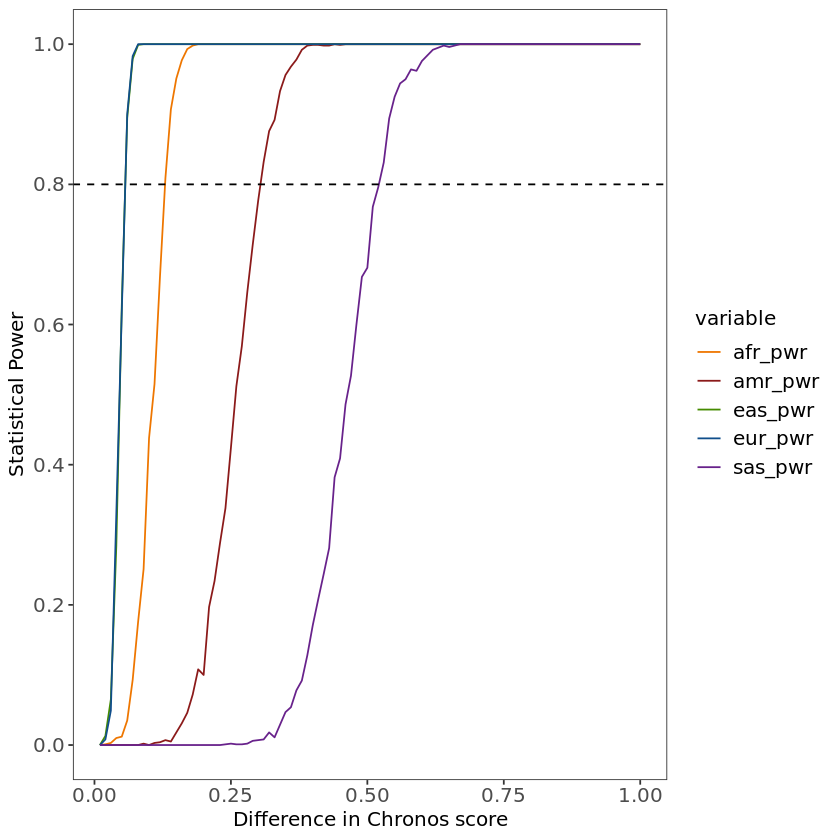

In [6]:
#Plot the plot of statistical power
statistical.power.df %>%
melt(id = "mean_difference") %>%
mutate(value = value/1000) %>%
ggplot(aes(x = mean_difference, y = value, color = variable)) +
geom_line() +

geom_hline(yintercept = 0.8 , linetype = 2) +

theme_bw() +

scale_color_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Statistical Power") +
xlab("Difference in Chronos score") +

scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1))

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("rf_power_calculation_statistical_power.pdf", width = 4, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp rf_power_calculation_statistical_power.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [156]:
###Next step is to compute the mean of all of the vectors
afr.pval.mean = afr.simulated.pvalues %>% lapply(mean) %>% unlist()
amr.pval.mean = amr.simulated.pvalues %>% lapply(mean) %>% unlist()
eas.pval.mean = eas.simulated.pvalues %>% lapply(mean) %>% unlist()
eur.pval.mean = eur.simulated.pvalues %>% lapply(mean) %>% unlist()
sas.pval.mean = sas.simulated.pvalues %>% lapply(mean) %>% unlist()

#Then combine everything into a single data frame
pval.df = cbind(mean.difference.vector, afr.pval.mean, amr.pval.mean, eas.pval.mean, eur.pval.mean, sas.pval.mean) %>%
data.frame() %>%
rename("mean_diff" = 1, "afr_pval" = 2, "amr_pval" = 3, "eas_pval" = 4, "eur_pval" = 5, "sas.pval" = 6) %>%
rbind(c(0, 1, 1, 1, 1, 1), .)


head(pval.df)

,mean_diff,afr_pval,amr_pval,eas_pval,eur_pval,sas.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,1.0000000,1.0000000,1.000000000,1.000000000,1.0000000
2,0.01,0.4557963,0.5166823,0.358949729,0.406818705,0.5027949
3,0.02,0.3822720,0.4866566,0.194865237,0.179643583,0.4569715
4,0.03,0.3368776,0.4613708,0.055095842,0.077273188,0.4195724
5,0.04,0.1912726,0.4001530,0.026145678,0.010189694,0.3985643
6,0.05,0.1607703,0.3695344,0.001252868,0.001454352,0.3838633


In [157]:
#Write the p-value dataframe so that we don't need to re-run all of that analysis.
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
write.table(pval.df, "power_calculation_pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [2]:
#Read the table back in
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
pval.df = read.table("power_calculation_pvals.txt", sep = "\t", header = TRUE)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite values (`stat_smooth()`).”


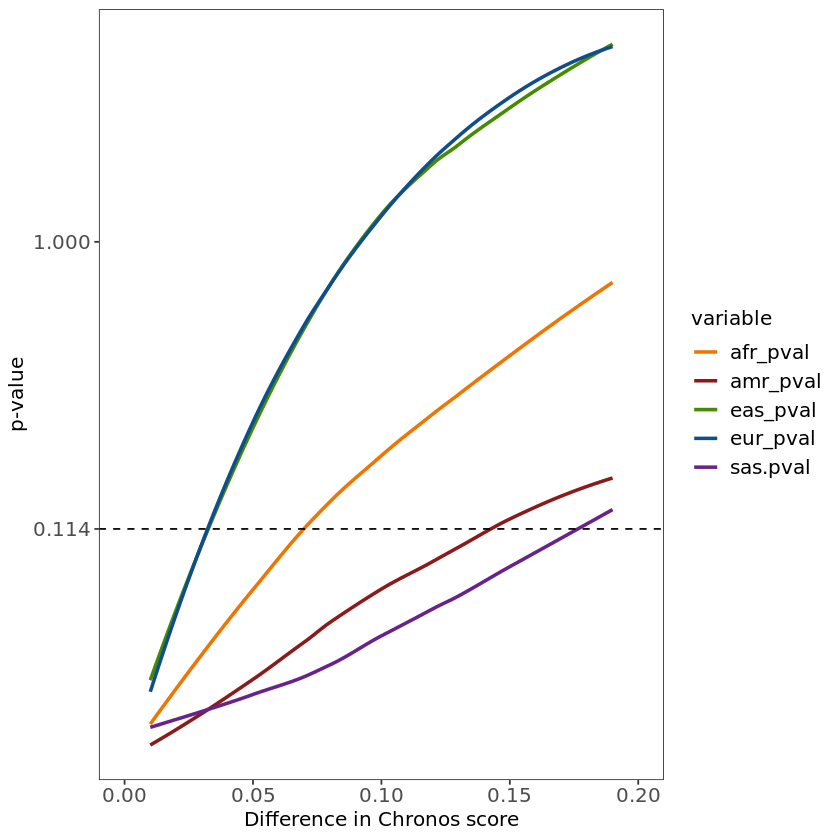

In [3]:
#Plot the plot 
pval.df %>% 
filter(mean_diff < 0.2) %>%
melt(id = "mean_diff") %>%
ggplot(aes(x = mean_diff, y = log10(-log10(value)), color = variable)) +
geom_smooth(se = FALSE) +

geom_hline(yintercept = 0.114, linetype = 2) +

theme_bw() +

scale_color_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_y_continuous(breaks = c(0.114, 1)) + #Ticks are at 0.05, 0.01, 10^-10
scale_x_continuous(limits = c(0, 0.2)) +

ylab("p-value") +
xlab("Difference in Chronos score")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("rf_power_calculation.pdf", width = 4, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp rf_power_calculation.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


In [141]:
pval.df %>% head()

,mean_diff,afr_pval,amr_pval,eas_pval,eur_pval,sas.pval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,1.0000000,1.0000000,1.000000000,1.000000000,1.0000000
2,0.01,0.4557963,0.5166823,0.358949729,0.406818705,0.5027949
3,0.02,0.3822720,0.4866566,0.194865237,0.179643583,0.4569715
4,0.03,0.3368776,0.4613708,0.055095842,0.077273188,0.4195724
5,0.04,0.1912726,0.4001530,0.026145678,0.010189694,0.3985643
6,0.05,0.1607703,0.3695344,0.001252868,0.001454352,0.3838633


# Num associations per ancestry group

The purpose of this section is to plot the number of significant associations per ancestry group.

In [4]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

head(lineage.corrected.pvals)

,gene,afr.lm.pval.vector,amr.lm.pval.vector,eas.lm.pval.vector,eur.lm.pval.vector,sas.lm.pval.vector,afr.mean.dif,amr.mean.dif,eas.mean.dif,eur.mean.dif,sas.mean.dif,afr_fdr,amr_fdr,eas_fdr,eur_fdr,sas_fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,0.51570812,0.5243904,0.33508618,0.51316820,1.0000000,0.018967685,0.039100054,-0.011154457,0.006603833,-0.226423809,0.998556,1,0.9184664,0.9703296,1
2,A1CF,0.09749307,0.9998859,0.73471568,0.70146509,0.5597664,-0.035117475,0.027514943,-0.002246655,0.007144719,0.030043081,0.998556,1,0.9771815,0.9821999,1
3,A2M,0.68035925,1.0000000,0.51713036,0.53660729,1.0000000,-0.010031350,0.038566520,-0.001514329,0.001920044,0.046502802,0.998556,1,0.9548815,0.9720597,1
4,A2ML1,0.61602149,0.6843036,0.09231594,0.06193838,1.0000000,0.009988105,0.013638286,0.009534186,-0.010934267,0.004499364,0.998556,1,0.7843746,0.8105684,1
5,A3GALT2,0.76637396,1.0000000,0.70909158,0.83017049,0.9866729,0.003320528,0.001137803,-0.016077768,0.014507092,-0.002840530,0.998556,1,0.9753693,0.9917531,1
6,A4GALT,0.87370145,1.0000000,0.13340200,0.13581386,1.0000000,0.004528391,0.019587428,-0.008987721,0.008747816,-0.096587268,0.998556,1,0.8209225,0.8739186,1


In [13]:
#Calculate the number of significant associations per ancestry group
num.sig.afr = lineage.corrected.pvals %>% filter(afr_fdr < 0.05) %>% nrow()
num.sig.amr = lineage.corrected.pvals %>% filter(amr_fdr < 0.05) %>% nrow()
num.sig.eas = lineage.corrected.pvals %>% filter(eas_fdr < 0.05) %>% nrow()
num.sig.eur = lineage.corrected.pvals %>% filter(eur_fdr < 0.05) %>% nrow()
num.sig.sas = lineage.corrected.pvals %>% filter(sas_fdr < 0.05) %>% nrow()
num.sig.any = lineage.corrected.pvals %>% filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>% pull(gene) %>% unique() %>% length()

In [14]:
#Print the data so that we can add this information to the paper
print(paste("the number of significant AFR genes is:", num.sig.afr))
print(paste("the number of significant AMR genes is:", num.sig.amr))
print(paste("the number of significant EAS genes is:", num.sig.eas))
print(paste("the number of significant EUR genes is:", num.sig.eur))
print(paste("the number of significant SAS genes is:", num.sig.sas))
print(paste("the number of significant genes (in any ancestry) is:", num.sig.any))

#Calculate the number of genes that are shared between eas and eur
eas.sig.gene.vector = lineage.corrected.pvals %>% filter(eas_fdr < 0.05) %>% pull(gene) %>% unique()
eur.sig.gene.vector = lineage.corrected.pvals %>% filter(eur_fdr < 0.05) %>% pull(gene) %>% unique()
eas.eur.intersection = intersect(eas.sig.gene.vector, eur.sig.gene.vector) %>% length()
print(paste("the number of intersecting EAS and EUR genes is:", eas.eur.intersection))

[1] "the number of significant AFR genes is: 24"
[1] "the number of significant AMR genes is: 3"
[1] "the number of significant EAS genes is: 18"
[1] "the number of significant EUR genes is: 17"
[1] "the number of significant SAS genes is: 1"
[1] "the number of significant genes (in any ancestry) is: 49"
[1] "the number of intersecting EAS and EUR genes is: 13"


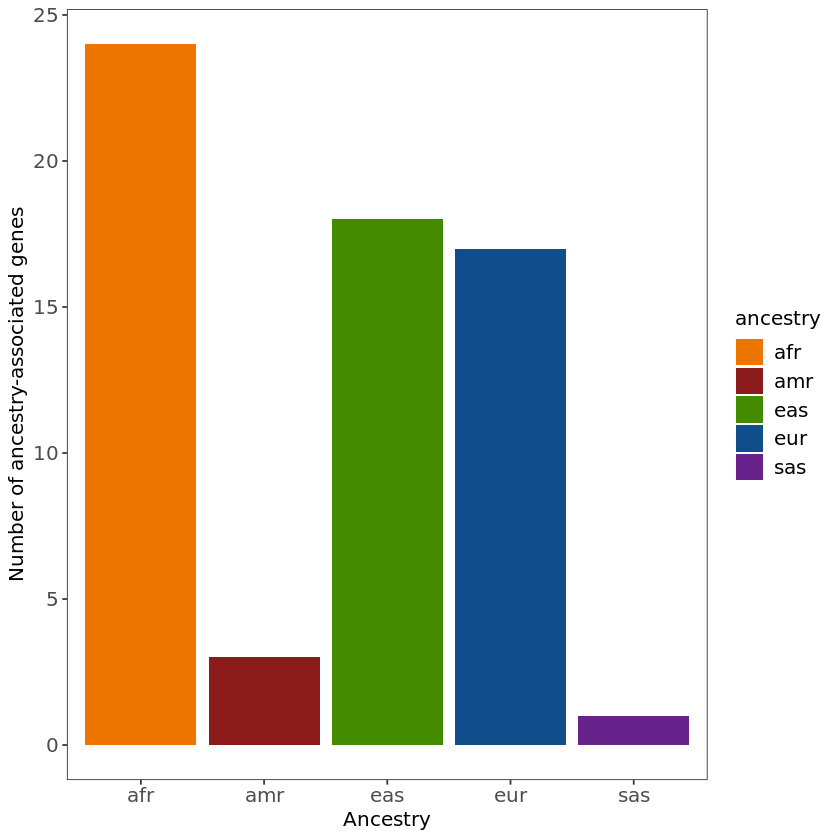

In [15]:
#Plot the data
num.gene.vector = c(num.sig.afr, num.sig.amr, num.sig.eas, num.sig.eur, num.sig.sas) 
ancestry.vector = c("afr", "amr", "eas", "eur", "sas")

cbind(ancestry.vector, num.gene.vector) %>%
data.frame() %>%
rename("ancestry" = 1, "num_genes" = 2) %>%
mutate(num_genes = as.numeric(num_genes)) %>%
ggplot(aes(x = ancestry, y = num_genes, fill = ancestry)) +
geom_bar(stat = "identity") +

theme_bw() +

scale_fill_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Number of ancestry-associated genes") +
xlab("Ancestry")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("num_sig_genes_barplot.pdf", width = 3, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp num_sig_genes_barplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Run GWAS for all of the ancestry-associated genes and create AF plot

In [29]:
#Make a vector of all of the ancestry-associated genes
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [30]:
#Load in the pre-correction chronos scores
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.22q1) = word(colnames(chronos.22q1), 1)

head(chronos.22q1)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


In [8]:
#Create a GWAS phenotype file
gwas.phenotype.file = chronos.22q1 %>%
rename("IID" = sample) %>%
select(IID, all_of(ancestry.associated.gene.vector))

#Write the file
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
write.table(gwas.phenotype.file, "chronos_gwas_phenotypes.pheno", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [9]:
#Run GWAS
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis
/home/jupyter/Ancestry/software/plink2/plink2 --allow-extra-chr --bfile ccle.snp6.imputed.final --maf 0.01 --glm hide-covar --pfilter 1 --covar 'iid-only' depmap.cov --pheno /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/chronos_gwas_phenotypes.pheno --out /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output/output
"))

In [10]:
#Load in all of the GWAS data and create a data matrix
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output")
file.list = list.files(path = ".", pattern = "glm.linear")

#extract the SNP IDs from the dataset
all.data = read.table(file.list[1], sep = "\t") %>%
pull(3) %>%
data.frame()

for(file in file.list){

    #Load in the file and select only the p-value column
    temp.file = read.table(file, sep = "\t") %>%
    pull(12) %>%
    data.frame()
    
    #Add the pvalues to the big file
    all.data = cbind(all.data, temp.file)
}

In [11]:
#Set the names correctly
#First, get a vector of names
col.name.vector = gsub("output.", "", file.list) %>%
gsub(".glm.linear", "", .) %>%
c("snp", .)
colnames(all.data) = col.name.vector #Assign the names
head(all.data)

#Write out the file so that we don't need to re-load and merge everything again
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output")
write.table(all.data, "merged.pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

,snp,ABHD5,ATOH1,ATP6V0E1,CAAP1,CCDC74B,CDKN2B,CHGB,CLSPN,DDX47,⋯,RHD,RHOB,RPL8,RPS5,SART1,SRP14,TEK,TUT1,UGT2B17,ZNF407
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:54490:G:A,0.0652707,0.884633,0.958745,0.688243,0.761643,0.164465,0.271946,0.977877,0.7459720,⋯,0.0260224,0.760653,0.788240,0.748180,0.381702,0.1004410,0.947344,0.721353,0.414801,0.786585
2,chr1:80346:C:G,0.2447680,0.296605,0.101084,0.028520,0.566924,0.845144,0.564637,0.210451,0.0141727,⋯,0.6667740,0.514686,0.412192,0.680442,0.478308,0.9054680,0.662483,0.221946,0.498739,0.838261
3,chr1:148488:A:G,0.4776400,0.217876,0.983748,0.510924,0.774947,0.483495,0.280720,0.544842,0.4462380,⋯,0.1327650,0.866477,0.910710,0.769040,0.989460,0.1007240,0.473092,0.443894,0.523597,0.945006
4,chr1:511511:C:A,0.4967390,0.162708,0.905933,0.446258,0.704119,0.464651,0.260332,0.462014,0.5529790,⋯,0.1436650,0.873468,0.955027,0.946972,0.838548,0.0904388,0.398043,0.479619,0.631723,0.917598
5,chr1:598941:G:A,0.6873320,0.970008,0.271329,0.436682,0.524696,0.436570,0.173389,0.734549,0.9471980,⋯,0.7317410,0.337384,0.267182,0.409667,0.429906,0.5870890,0.999470,0.888868,0.840718,0.921749
6,chr1:665098:G:A,0.7081250,0.634340,0.359322,0.264381,0.741993,0.308600,0.492987,0.770940,0.2074870,⋯,0.0950265,0.567682,0.591660,0.806332,0.552903,0.7169320,0.614289,0.710559,0.917770,0.817819


In [17]:
#Create a dataset that has the top snp for all of the ancestry-associated genes
top.snp.df = NULL
for(i in 1:length(ancestry.associated.gene.vector)){
    
    #Get the gene of interest from this iteration of the loop
    gene.of.interest = ancestry.associated.gene.vector[i]
    
    #Create a small dataset with only the snp of interest
    subset.df = all.data %>%
    select(snp, all_of(gene.of.interest)) %>%
    rename("pval" = 2) %>%
    arrange(pval) %>%
    mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
    head(n = 1)
    
    #Add it to the df outside of the loop
    top.snp.df = rbind(top.snp.df, subset.df)
    
}

#Add in the gene name
top.snp.df = top.snp.df %>% mutate("gene" = ancestry.associated.gene.vector, .before = 1)

In [112]:
#Write top.snp.df so that we can load it back in for other analyses
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
write.table(top.snp.df, "ancestry_top_snp_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [31]:
#Read the data back in if needed
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

In [32]:
#Get a vector of all of the significant SNPs
significant.snp.vector = top.snp.df %>%
filter(fdr < 0.05) %>%
pull(snp)

significant.snp.vector %>% length()

[1] 33

In [33]:
#Figure out which snp is associated with cdkn2b
top.snp.df %>% filter(gene %in% "CDKN2B")

gene,snp,pval,fdr
<chr>,<chr>,<dbl>,<dbl>
CDKN2B,chr9:21986219:C:T,1.63496e-15,2.696571e-07


We want to make a figure that will show the allele frequency of each SNP across cell line ancestry

In [27]:
#First, create a bed file so that we can subset the ccle genotyping dataset
ancestry.snp.bed.for.subsetting = top.snp.df %>%
select(-gene, -pval, -fdr) %>%
separate(snp, sep = ":", into = c("chr", "pos", "ref", "alt")) %>%
select(-ref, -alt) %>%
mutate(pos = as.numeric(pos)) %>%
mutate("low_pos" = pos - 10) %>%
mutate("high_pos" = pos + 10) %>%
select(-pos)

#Write the bed file
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
write.table(ancestry.snp.bed.for.subsetting, "ancestry_subsetting.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)

In [31]:
#Subset the genotyping matrix
system(glue::glue("
/home/jupyter/Ancestry/software/bcftools/bcftools filter /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/split.all_chroms.maf.subset.reheader.vcf.gz -R /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/ancestry_subsetting.bed -o /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/ccle.ancestry.snps.vcf.gz -Oz
"))

#Extract the sample names from the vcf file
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis/split.all_chroms.maf.subset.reheader.vcf.gz > ccle.vcf.sample.names.txt
"))

In [34]:
#Load in the vcf sample names
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/")
ccle.vcf.sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(V1)


#Load in the genotyping matrix and format it
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/")
formatted.ancestry.snp.genotyping.matrix = read.table("ccle.ancestry.snps.vcf.gz", sep = "\t") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9) %>%
rename("snp" = V3) %>%
filter(snp %in% all_of(top.snp.df$snp))


#Do the final steps of formatting to adjust the genotype call format
final.ancestry.snp.genotyping.matrix = formatted.ancestry.snp.genotyping.matrix %>%
select(-snp) %>%
mutate_all(funs(gsub(":..*", "", .))) %>%
mutate_all(funs(gsub("0\\|0", "0", .))) %>%
mutate_all(funs(gsub("0\\|1", "1", .))) %>%
mutate_all(funs(gsub("1\\|0", "1", .))) %>%
mutate_all(funs(gsub("1\\|1", "2", .))) %>%
mutate("snp" = formatted.ancestry.snp.genotyping.matrix$snp, .before = 1)


#Set the column names
colnames(final.ancestry.snp.genotyping.matrix) = c("snp", ccle.vcf.sample.names)


#Get a list of samples to keep that intersect between the genotyping matrix and the chronos matrix
samples.to.keep = intersect(colnames(final.ancestry.snp.genotyping.matrix), chronos.22q1$sample)


#Filter the dataset so that it only includes the samples that have chronos scores.
final.ancestry.snp.genotyping.matrix = final.ancestry.snp.genotyping.matrix %>%
select(snp, all_of(samples.to.keep))


head(final.ancestry.snp.genotyping.matrix)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


,snp,ACH-000657,ACH-000685,ACH-000632,ACH-000863,ACH-000971,ACH-000178,ACH-000822,ACH-000713,ACH-000042,⋯,ACH-000554,ACH-000352,ACH-000405,ACH-000274,ACH-000894,ACH-000935,ACH-000217,ACH-000116,ACH-000986,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr19:3997016:C:G,2,2,0,0,1,0,0,0,0,⋯,0,0,1,0,0,1,0,0,0,0
2,chr19:10327278:A:G,2,2,0,0,1,0,0,2,1,⋯,0,0,0,0,2,1,0,0,1,2
3,chr19:58384583:C:G,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
4,chr6:38214637:C:T,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr6:89776606:T:C,0,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
6,chr6:117239254:T:C,2,2,2,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2


In [35]:
#Load in the data that lists the ancestry group for all of the cell lines
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.data = read.table("collapsed.ancestry.information.txt", sep = "\t", header = TRUE) %>%
mutate("max_ancestry" = ifelse(AFR >= 0.8, "afr", 
                              ifelse(AMR >= 0.8, "amr",
                                    ifelse(EAS >= 0.8, "eas",
                                          ifelse(EUR >= 0.8, "eur",
                                                ifelse(SAS >= 0.8, "sas", "admixed")))))) %>%
filter(sample %in% all_of(samples.to.keep))


#Create vectors that have all of the lines by ancestry
afr.lines = rfmix.data %>% filter(max_ancestry %in% "afr") %>% pull(sample)
amr.lines = rfmix.data %>% filter(max_ancestry %in% "amr") %>% pull(sample)
eas.lines = rfmix.data %>% filter(max_ancestry %in% "eas") %>% pull(sample)
eur.lines = rfmix.data %>% filter(max_ancestry %in% "eur") %>% pull(sample)
sas.lines = rfmix.data %>% filter(max_ancestry %in% "sas") %>% pull(sample)
admixed.lines = rfmix.data %>% filter(max_ancestry %in% "admixed") %>% pull(sample)

In [36]:
#Calculate the frequency of every SNP in the population
afr.frequency = final.ancestry.snp.genotyping.matrix %>% 
select(snp, all_of(afr.lines)) %>% 
melt(id = "snp") %>% 
mutate(value = as.numeric(value)) %>% 
group_by(snp) %>%
summarise("num_alleles_afr" = sum(value))

eas.frequency = final.ancestry.snp.genotyping.matrix %>% 
select(snp, all_of(eas.lines)) %>% 
melt(id = "snp") %>% 
mutate(value = as.numeric(value)) %>% 
group_by(snp) %>%
summarise("num_alleles_eas" = sum(value))

eur.frequency = final.ancestry.snp.genotyping.matrix %>% 
select(snp, all_of(eur.lines)) %>% 
melt(id = "snp") %>% 
mutate(value = as.numeric(value)) %>% 
group_by(snp) %>%
summarise("num_alleles_eur" = sum(value))

admixed.frequency = final.ancestry.snp.genotyping.matrix %>% 
select(snp, all_of(admixed.lines)) %>% 
melt(id = "snp") %>% 
mutate(value = as.numeric(value)) %>% 
group_by(snp) %>%
summarise("num_alleles_admixed" = sum(value))

total.frequency = final.ancestry.snp.genotyping.matrix %>% 
melt(id = "snp") %>% 
mutate(value = as.numeric(value)) %>% 
group_by(snp) %>%
summarise("num_alleles_total" = sum(value))


#Group everything into a single dataset
merged.frequency.dataset = afr.frequency %>%
inner_join(eas.frequency, by = "snp") %>%
inner_join(eur.frequency, by = "snp") %>%
inner_join(admixed.frequency, by = "snp") %>%
inner_join(total.frequency, by = "snp") %>%
mutate("afr_allele_fraction" = num_alleles_afr/(2*length(afr.lines))) %>%
mutate("eas_allele_fraction" = num_alleles_eas/(2*length(eas.lines))) %>%
mutate("eur_allele_fraction" = num_alleles_eur/(2*length(eur.lines))) %>%
mutate("admixed_allele_fraction" = num_alleles_admixed/(2*length(admixed.lines))) %>%
mutate("total_allele_fraction" = num_alleles_total/(2*nrow(rfmix.data)))


head(merged.frequency.dataset)

snp,num_alleles_afr,num_alleles_eas,num_alleles_eur,num_alleles_admixed,num_alleles_total,afr_allele_fraction,eas_allele_fraction,eur_allele_fraction,admixed_allele_fraction,total_allele_fraction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:109297547:C:T,0,0,16,0,16,0.000,0.000000000,0.020833333,0.000,0.012638231
chr1:161637565:G:T,20,149,494,16,683,0.500,0.359903382,0.643229167,0.400,0.539494471
chr1:230980609:C:T,0,1,7,1,9,0.000,0.002415459,0.009114583,0.025,0.007109005
chr1:25235176:G:A,2,8,260,10,283,0.050,0.019323671,0.338541667,0.250,0.223538705
chr1:35775729:T:C,15,95,663,24,798,0.375,0.229468599,0.863281250,0.600,0.630331754
chr1:73819660:G:A,1,0,13,0,14,0.025,0.000000000,0.016927083,0.000,0.011058452


In [37]:
#Export the dataset
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
write.table(merged.frequency.dataset, "merged_frequency_dataset.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

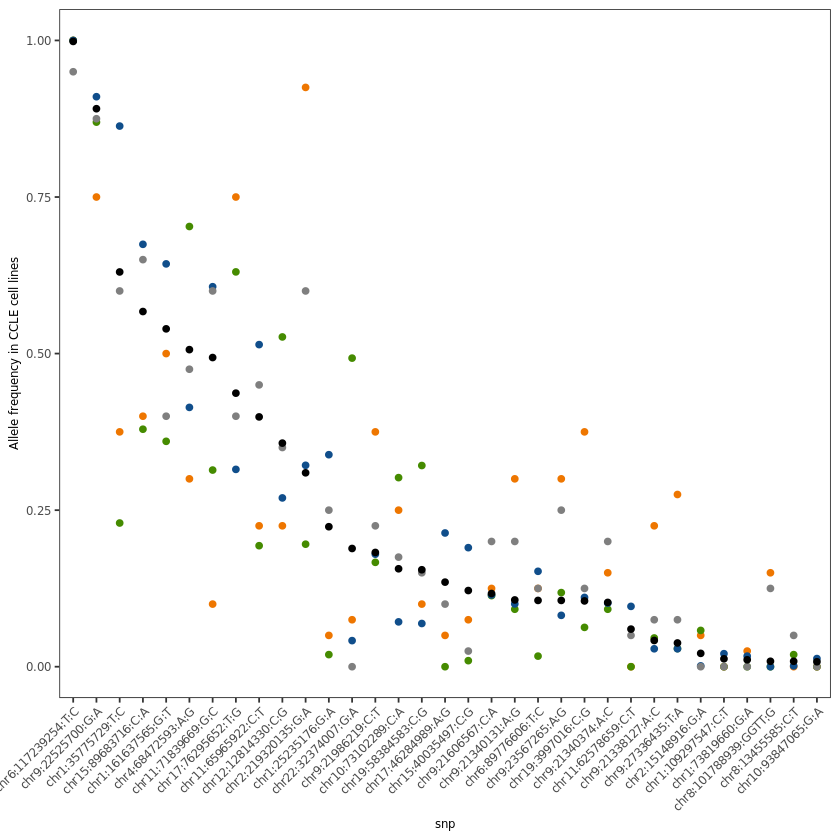

In [21]:
#Plot the plot
merged.frequency.dataset %>% 
filter(snp %in% all_of(significant.snp.vector)) %>%
arrange(desc(total_allele_fraction)) %>%
mutate(snp = factor(snp, levels = fct_inorder(snp))) %>%
select(snp, afr_allele_fraction, eas_allele_fraction, eur_allele_fraction, admixed_allele_fraction, total_allele_fraction) %>%
mutate("gene" = plyr::mapvalues(from = top.snp.df$snp, to = top.snp.df$gene, snp, warn_missing = FALSE)) %>%

ggplot() +
geom_point(aes(x = snp, y = afr_allele_fraction), color = "darkorange2") +
geom_point(aes(x = snp, y = eas_allele_fraction), color = "chartreuse4") +
geom_point(aes(x = snp, y = eur_allele_fraction), color = "dodgerblue4") +
geom_point(aes(x = snp, y = admixed_allele_fraction), color = "grey50") +
geom_point(aes(x = snp, y = total_allele_fraction), color = "black") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

ylab("Allele frequency in CCLE cell lines") 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("af_dot_plot.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp af_dot_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [31]:
#Write out the file so that we don't need to re-load and merge everything again
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output")
all.data = read.table("merged.pvals.txt", sep = "\t", header = TRUE)

Perform an analysis of these data to create the same histogram plot that I had before

In [34]:
differential.frequency.df = merged.frequency.dataset %>% 
filter(snp %in% all_of(significant.snp.vector)) %>%
arrange(desc(total_allele_fraction)) %>%
mutate(snp = factor(snp, levels = fct_inorder(snp))) %>%
select(snp, afr_allele_fraction, eas_allele_fraction, eur_allele_fraction, admixed_allele_fraction, total_allele_fraction) %>%
mutate("gene" = plyr::mapvalues(from = top.snp.df$snp, to = top.snp.df$gene, snp, warn_missing = FALSE)) %>%
relocate(gene, .before = 1) %>%
mutate("afr_differential" = afr_allele_fraction - total_allele_fraction) %>%
mutate("eas_differential" = eas_allele_fraction - total_allele_fraction) %>%
mutate("eur_differential" = eur_allele_fraction - total_allele_fraction) %>%
mutate("admixed_differential" = admixed_allele_fraction - total_allele_fraction)

differential.frequency.df %>% head()

gene,snp,afr_allele_fraction,eas_allele_fraction,eur_allele_fraction,admixed_allele_fraction,total_allele_fraction,afr_differential,eas_differential,eur_differential,admixed_differential
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATOH1,chr6:117239254:T:C,1.000,1.0000000,1.0000000,0.950,0.9984202,0.001579779,0.001579779,0.001579779,-0.04842022
DMRTA1,chr9:22525700:G:A,0.750,0.8695652,0.9101562,0.875,0.8909953,-0.140995261,-0.021430043,0.019160989,-0.01599526
CLSPN,chr1:35775729:T:C,0.375,0.2294686,0.8632812,0.600,0.6303318,-0.255331754,-0.400863155,0.232949496,-0.03033175
PEX11A,chr15:89683716:C:A,0.400,0.3792271,0.6744792,0.650,0.5671406,-0.167140600,-0.187913547,0.107338566,0.08285940
FCGR3A,chr1:161637565:G:T,0.500,0.3599034,0.6432292,0.400,0.5394945,-0.039494471,-0.179591089,0.103734696,-0.13949447
UGT2B17,chr4:68472593:A:G,0.300,0.7028986,0.4140625,0.475,0.5063191,-0.206319115,0.196579435,-0.092256615,-0.03131912


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


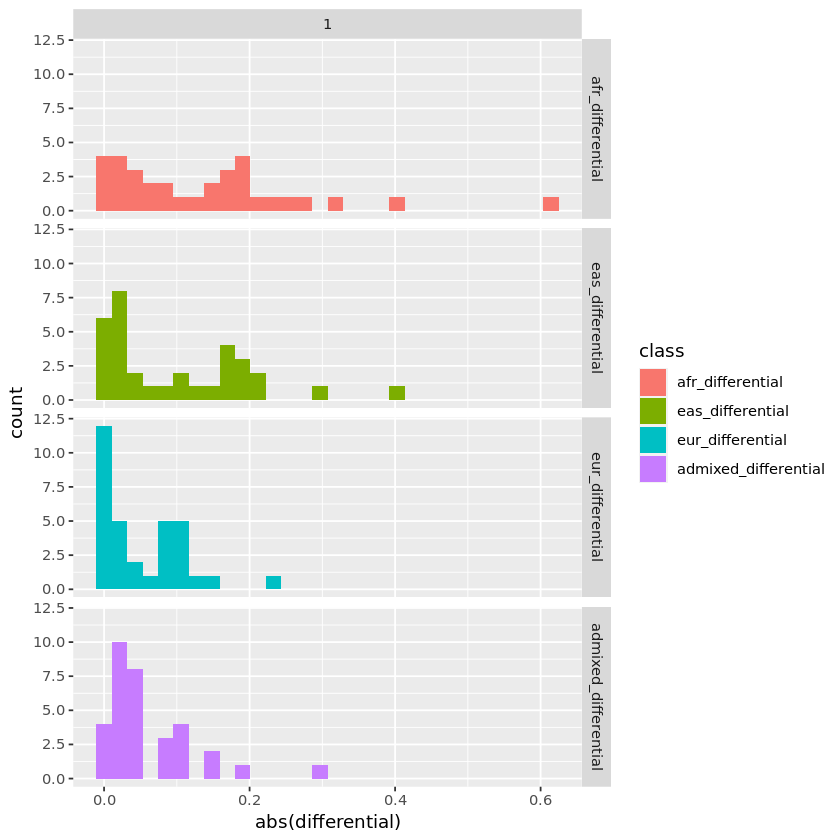

In [42]:
#Plot the plot
differential.frequency.df %>%
select(-afr_allele_fraction, -eas_allele_fraction, -eur_allele_fraction, -admixed_allele_fraction, -total_allele_fraction, -gene) %>%
melt(id = "snp") %>%
rename("class" = variable, "differential" = value) %>%
ggplot(aes(x = abs(differential), fill = class)) +
geom_histogram() +
facet_grid(class ~ 1) 


Perform an analysis to calculate the number of SNPs where the AFmax - AFmin is > 0.2

In [33]:
#Assemble the data frame to calculate the differential between the min and max ancestry
num.ancestry.associated = merged.frequency.dataset %>%
select(snp, afr_allele_fraction, eas_allele_fraction, eur_allele_fraction, admixed_allele_fraction) %>%
rowwise() %>%
mutate("min_value" = min(c_across(afr_allele_fraction:admixed_allele_fraction))) %>%
rowwise() %>%
mutate("max_value" = max(c_across(afr_allele_fraction:admixed_allele_fraction))) %>%
mutate("differential" = max_value - min_value)

#Calculate the number of differential SNPs
num.ancestry.associated %>%
filter(differential > 0.2) %>%
pull(snp) %>% 
unique() %>%
length()

[1] 25

# Make a plot analyzing the proximal vs distal SNPs

This analysis will plot the significance of the association vs the location of the SNP (relative to the TSS)

In [50]:
#Make a vector of all of the ancestry-associated genes
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [51]:
#Find the TSS for all of the ancestry-associated genes.
setwd("/home/jupyter/Ancestry/analysis/locus_specific_gwas_analysis")
refgene = read.table("hg38.refGene.gtf", header = F, sep = "\t") %>%
select(V1, V3, V4, V5, V7, V9) %>%
rename("chr" = V1, "type" = V3, "start" = V4, "end" = V5, "strand" = V7, "gene" = V9) %>%
filter(type %in% "transcript") %>%
mutate("position" = ifelse(strand %in% "+", start, end)) %>%
mutate(gene = gsub(";..*", "", gene)) %>%
mutate(gene = gsub("gene_id ", "", gene)) %>%
select(chr, position, strand, gene) %>%
filter(gene %in% ancestry.associated.gene.vector) %>%
distinct(gene, .keep_all = TRUE)

head(refgene)
dim(refgene)

,chr,position,strand,gene
,<chr>,<int>,<chr>,<chr>
1,chr9,27109141,+,TEK
2,chr1,25272486,+,RHD
3,chr9,21802636,+,MTAP
4,chr9,21031640,-,HACD4
5,chr2,219333177,-,RESP18
6,chr10,73168095,-,ECD


[1] 49  4

In [52]:
#Load in the top SNP data
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

In [53]:
#Create a merged dataset that has both the tss data and the significance data
merged.tss.and.sig.df = top.snp.df %>% 
inner_join(refgene, by = "gene") %>%
rename("tss_chr" = chr, "tss_pos" = position, "tss_strand"  = strand) %>%
separate(snp, sep = ":", into = c("top_snp_chr", "top_snp_pos", "top_snp_ref", "top_snp_alt")) %>%
select(-top_snp_ref, -top_snp_alt, -pval) %>%
mutate(top_snp_pos = as.numeric(top_snp_pos)) %>%
mutate("distance_to_tss" = ifelse(top_snp_chr == tss_chr, abs(top_snp_pos - tss_pos), 1000001)) %>%
mutate("prox_or_dist" = ifelse(distance_to_tss < 1000000, "proximal", "distal"))


head(merged.tss.and.sig.df)
dim(merged.tss.and.sig.df)

,gene,top_snp_chr,top_snp_pos,fdr,tss_chr,tss_pos,tss_strand,distance_to_tss,prox_or_dist
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<chr>
1,ABHD5,chr19,10327278,1.000000e+00,chr3,43690870,+,1000001,distal
2,ATOH1,chr6,117239254,3.064682e-18,chr4,93828753,+,1000001,distal
3,ATP6V0E1,chr2,15148916,7.200293e-04,chr5,172983771,+,1000001,distal
4,CAAP1,chr9,26820990,1.000000e+00,chr9,26892802,-,71812,proximal
5,CCDC74B,chr3,70154405,1.000000e+00,chr2,130145134,-,1000001,distal
6,CDKN2B,chr9,21986219,2.696571e-07,chr9,22009313,-,23094,proximal


[1] 49  9

In [54]:
#Calculate the number of proximal and distal genes
total.proximal = merged.tss.and.sig.df %>% filter(prox_or_dist %in% "proximal") %>% pull(gene) %>% unique() %>% length()
total.distal = merged.tss.and.sig.df %>% filter(prox_or_dist %in% "distal") %>% pull(gene) %>% unique() %>% length()

#Print the information
print(paste("the total number of proximal genes is:", total.proximal))
print(paste("the total number of distal genes is:", total.distal))

[1] "the total number of proximal genes is: 29"
[1] "the total number of distal genes is: 20"


In [55]:
#Write the table for future use
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
write.table(merged.tss.and.sig.df, "distance_to_tss_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

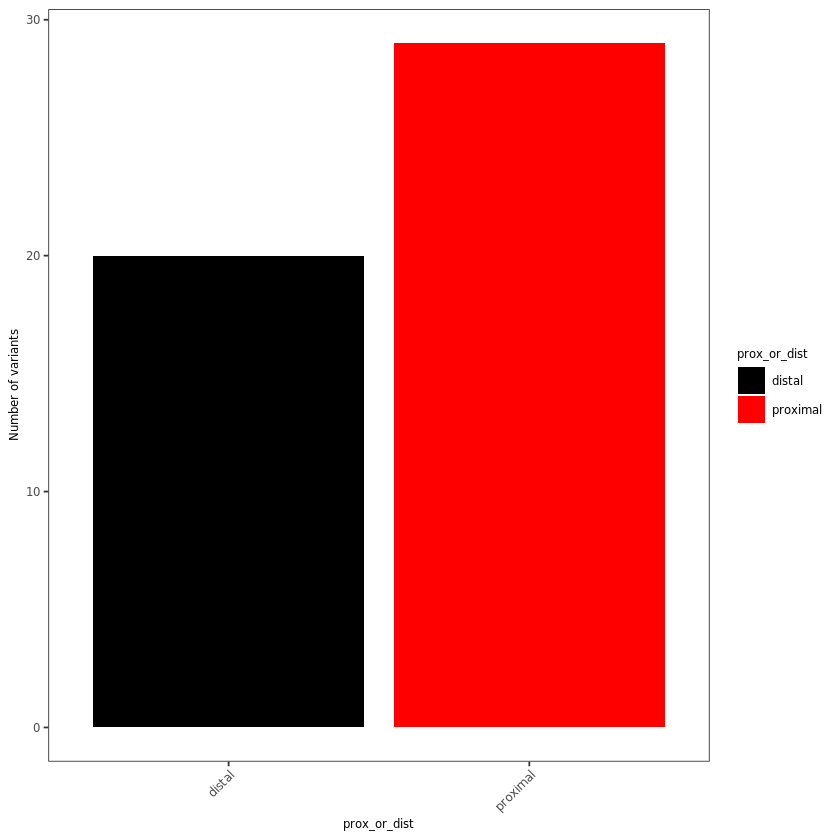

In [56]:
#Create a simple plot that shows the fraction of variants that are proximal vs distal
merged.tss.and.sig.df %>%
group_by(prox_or_dist) %>%
summarise("num" = n()) %>%
ggplot(aes(x = prox_or_dist, y = num, fill = prox_or_dist)) +
geom_bar(stat = "identity") +
theme_bw() +

scale_fill_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

ylab("Number of variants") 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("prox_dist_plot.pdf", width = 2.5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp prox_dist_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

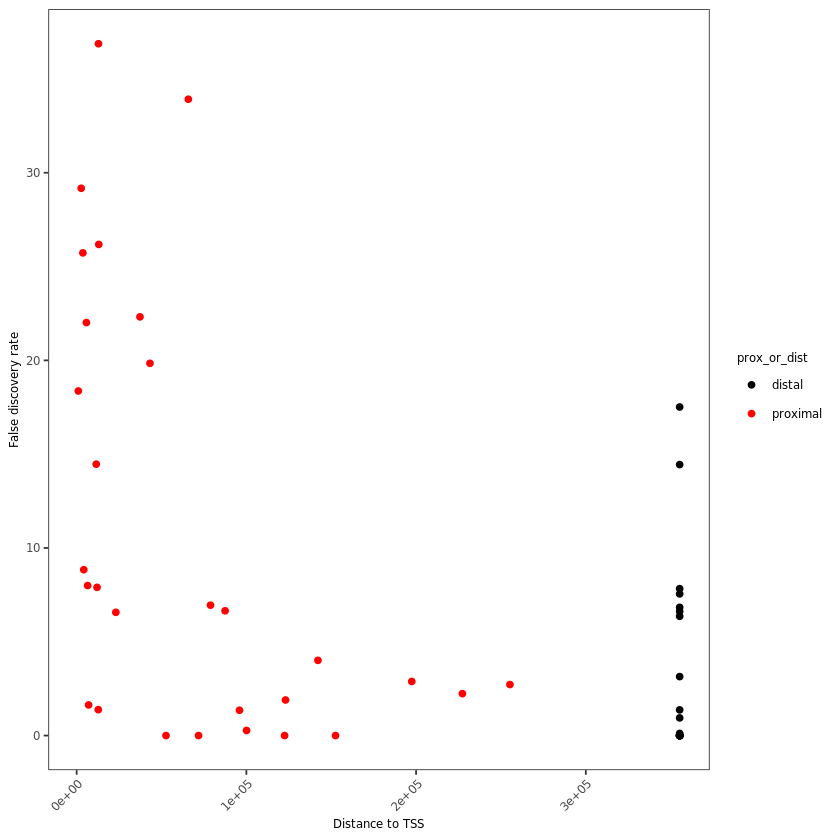

In [58]:
###Plot the FDR vs distance to tss

#Calculate the maximum distance for the proximal variants
max.dist.to.tss = merged.tss.and.sig.df %>%
filter(prox_or_dist %in% "proximal") %>%
pull(distance_to_tss) %>%
max()


#Make a plot of fdr vs distance to tss
merged.tss.and.sig.df %>%
mutate(distance_to_tss = ifelse(distance_to_tss > max.dist.to.tss, max.dist.to.tss + 100000, distance_to_tss)) %>%

ggplot(aes(x = distance_to_tss, y = -log10(fdr), color = prox_or_dist, fill = prox_or_dist)) +
geom_point() +
theme_bw() +

scale_color_manual(values = c("black", "red")) +
scale_fill_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

ylab("False discovery rate") +
xlab("Distance to TSS")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("distance_to_tss_plot.pdf", width = 3, height = 2.95)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp distance_to_tss_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Generate the same plots except after filting to only include variants with a significant fdr

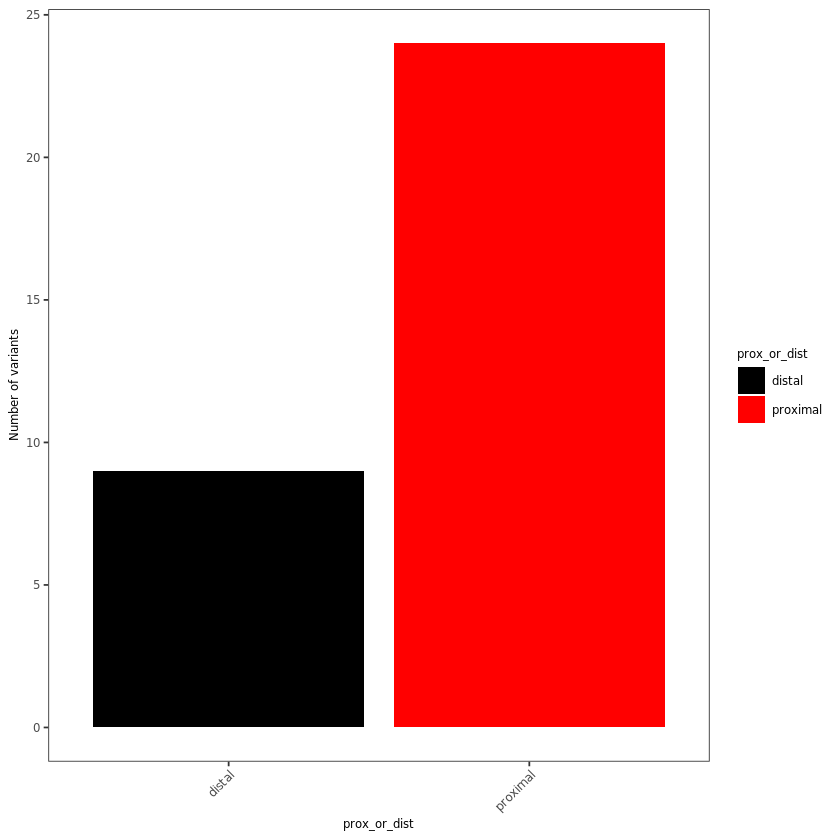

In [7]:
#Create a simple plot that shows the fraction of variants that are proximal vs distal
merged.tss.and.sig.df %>%
filter(fdr < 0.05) %>%
group_by(prox_or_dist) %>%
summarise("num" = n()) %>%
ggplot(aes(x = prox_or_dist, y = num, fill = prox_or_dist)) +
geom_bar(stat = "identity") +
theme_bw() +

scale_fill_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

ylab("Number of variants") 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("only_sig_prox_dist_plot.pdf", width = 2.5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp only_sig_prox_dist_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

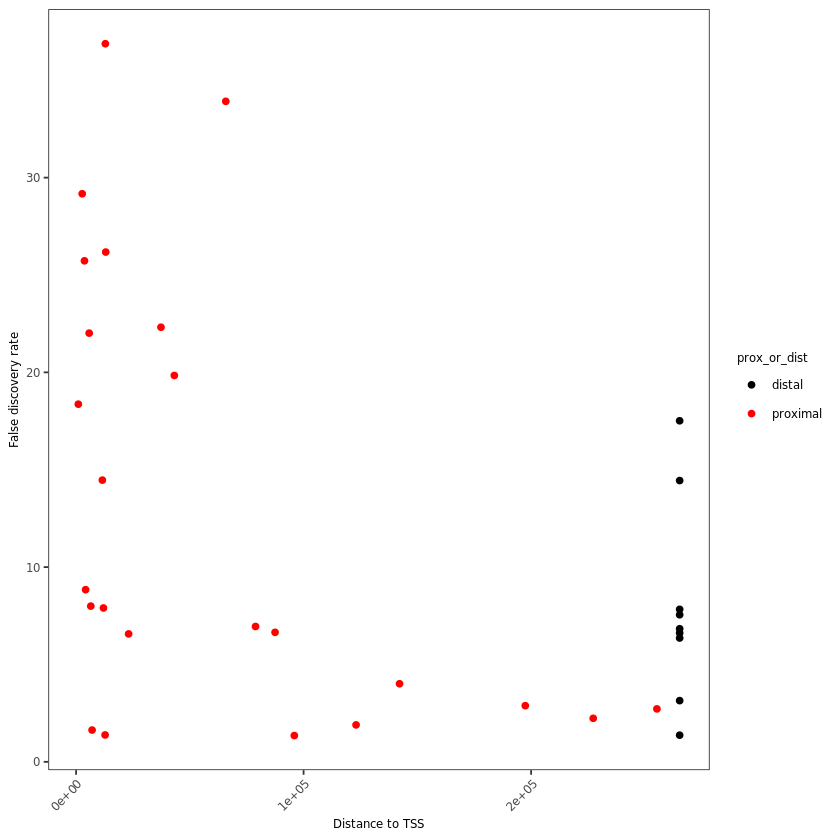

In [9]:
###Plot the FDR vs distance to tss

#Calculate the maximum distance for the proximal variants
max.dist.to.tss = merged.tss.and.sig.df %>%
filter(fdr < 0.05) %>%
filter(prox_or_dist %in% "proximal") %>%
pull(distance_to_tss) %>%
max()


#Make a plot of fdr vs distance to tss
merged.tss.and.sig.df %>%
filter(fdr < 0.05) %>%
mutate(distance_to_tss = ifelse(distance_to_tss > max.dist.to.tss, max.dist.to.tss + 10000, distance_to_tss)) %>%

ggplot(aes(x = distance_to_tss, y = -log10(fdr), color = prox_or_dist, fill = prox_or_dist)) +
geom_point() +
theme_bw() +

scale_color_manual(values = c("black", "red")) +
scale_fill_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

ylab("False discovery rate") +
xlab("Distance to TSS")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("only_sig_distance_to_tss_plot.pdf", width = 3.5, height = 2.95)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp only_sig_distance_to_tss_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now do some analysis of the total number of p-values for each 

In [9]:
#Load in the compiled pvalue data frame
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output")
all.data = read.table("merged.pvals.txt", sep = "\t", header = TRUE)

head(all.data)

,snp,ABHD5,ATOH1,ATP6V0E1,CAAP1,CCDC74B,CDKN2B,CHGB,CLSPN,DDX47,⋯,RHD,RHOB,RPL8,RPS5,SART1,SRP14,TEK,TUT1,UGT2B17,ZNF407
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:54490:G:A,0.0652707,0.884633,0.958745,0.688243,0.761643,0.164465,0.271946,0.977877,0.7459720,⋯,0.0260224,0.760653,0.788240,0.748180,0.381702,0.1004410,0.947344,0.721353,0.414801,0.786585
2,chr1:80346:C:G,0.2447680,0.296605,0.101084,0.028520,0.566924,0.845144,0.564637,0.210451,0.0141727,⋯,0.6667740,0.514686,0.412192,0.680442,0.478308,0.9054680,0.662483,0.221946,0.498739,0.838261
3,chr1:148488:A:G,0.4776400,0.217876,0.983748,0.510924,0.774947,0.483495,0.280720,0.544842,0.4462380,⋯,0.1327650,0.866477,0.910710,0.769040,0.989460,0.1007240,0.473092,0.443894,0.523597,0.945006
4,chr1:511511:C:A,0.4967390,0.162708,0.905933,0.446258,0.704119,0.464651,0.260332,0.462014,0.5529790,⋯,0.1436650,0.873468,0.955027,0.946972,0.838548,0.0904388,0.398043,0.479619,0.631723,0.917598
5,chr1:598941:G:A,0.6873320,0.970008,0.271329,0.436682,0.524696,0.436570,0.173389,0.734549,0.9471980,⋯,0.7317410,0.337384,0.267182,0.409667,0.429906,0.5870890,0.999470,0.888868,0.840718,0.921749
6,chr1:665098:G:A,0.7081250,0.634340,0.359322,0.264381,0.741993,0.308600,0.492987,0.770940,0.2074870,⋯,0.0950265,0.567682,0.591660,0.806332,0.552903,0.7169320,0.614289,0.710559,0.917770,0.817819


In [ ]:
#create a dataset that only includes significant variants for each gene
only.significant.fdrs = all.data %>%
select(-snp) %>%
apply(2, function(x){ p.adjust(x, method = "BY", n = length(x))}) %>%
mutate("snp" = all.data$snp, .before = 1)

only.significant.fdrs %>% head()

# Analyze if ancestry-associated variants are eQTLs

In [3]:
#Make a vector of all of the ancestry-associated genes
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [4]:
#Load in the top SNP data
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

In [5]:
#Load in the pre-correction chronos scores
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.22q1) = word(colnames(chronos.22q1), 1)

head(chronos.22q1)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


In [6]:
#Load in the vcf sample names
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/")
ccle.vcf.sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(V1)


#Load in the genotyping matrix and format it
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/")
formatted.ancestry.snp.genotyping.matrix = read.table("ccle.ancestry.snps.vcf.gz", sep = "\t") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9) %>%
rename("snp" = V3) %>%
filter(snp %in% all_of(top.snp.df$snp))


#Do the final steps of formatting to adjust the genotype call format
final.ancestry.snp.genotyping.matrix = formatted.ancestry.snp.genotyping.matrix %>%
select(-snp) %>%
mutate_all(funs(gsub(":..*", "", .))) %>%
mutate_all(funs(gsub("0\\|0", "0", .))) %>%
mutate_all(funs(gsub("0\\|1", "1", .))) %>%
mutate_all(funs(gsub("1\\|0", "1", .))) %>%
mutate_all(funs(gsub("1\\|1", "2", .))) %>%
mutate("snp" = formatted.ancestry.snp.genotyping.matrix$snp, .before = 1)


#Set the column names
colnames(final.ancestry.snp.genotyping.matrix) = c("snp", ccle.vcf.sample.names)


#Get a list of samples to keep that intersect between the genotyping matrix and the chronos matrix
samples.to.keep = intersect(colnames(final.ancestry.snp.genotyping.matrix), chronos.22q1$sample)


#Filter the dataset so that it only includes the samples that have chronos scores.
final.ancestry.snp.genotyping.matrix = final.ancestry.snp.genotyping.matrix %>%
select(snp, all_of(samples.to.keep))


head(final.ancestry.snp.genotyping.matrix)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


,snp,ACH-000657,ACH-000685,ACH-000632,ACH-000863,ACH-000971,ACH-000178,ACH-000822,ACH-000713,ACH-000042,⋯,ACH-000554,ACH-000352,ACH-000405,ACH-000274,ACH-000894,ACH-000935,ACH-000217,ACH-000116,ACH-000986,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr19:3997016:C:G,2,2,0,0,1,0,0,0,0,⋯,0,0,1,0,0,1,0,0,0,0
2,chr19:10327278:A:G,2,2,0,0,1,0,0,2,1,⋯,0,0,0,0,2,1,0,0,1,2
3,chr19:58384583:C:G,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
4,chr6:38214637:C:T,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr6:89776606:T:C,0,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
6,chr6:117239254:T:C,2,2,2,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2


In [7]:
#Load in the expression data
ccle.expression.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CCLE_expression') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(ccle.expression.22q1) = word(colnames(ccle.expression.22q1), 1)

#Filter the expression data so that it only includes ancestry-associated genes and melt it
ancestry.only.expression.22q1 = ccle.expression.22q1 %>%
select(sample, all_of(ancestry.associated.gene.vector)) %>%
melt()

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_ccle-expression.rds

Using sample as id variables



In [8]:
#Load in a dataset with the lineage information for each cell line
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

head(sample.annotation)

,sample,primary_disease
,<chr>,<chr>
1,ACH-000001,Ovarian Cancer
2,ACH-000002,Leukemia
3,ACH-000003,Colon/Colorectal Cancer
4,ACH-000004,Leukemia
5,ACH-000005,Leukemia
6,ACH-000006,Leukemia


In [9]:
#For each SNP:Gene pair, compute if that SNP is associated with expression of the chronos gene in question
eqtl.association.pval = NULL
eqtl.association.differential.expression = NULL
for(i in 1:nrow(top.snp.df)){
    
    #Store the snp and gene for this iteration of a loop as a new variable
    gene.of.interest = top.snp.df[i, 1]
    snp.of.interest = top.snp.df[i, 2]
    
    
    #Calculate the intersection between all of the samples with expression profiles and all of the genotyped samples
    all.genotyped.samples = final.ancestry.snp.genotyping.matrix %>% melt(id = "snp") %>% pull(variable) %>% unique()
    all.samples.with.expression = ancestry.only.expression.22q1 %>% pull(sample) %>% unique()
    all.intersecting.samples = intersect(all.genotyped.samples, all.samples.with.expression)
    
    
    #Get a vector of cell lines that have the snp or don't have the snp
    lines.with.snp = final.ancestry.snp.genotyping.matrix %>%
    melt(id = "snp") %>%
    filter(variable %in% all_of(all.intersecting.samples)) %>%
    filter(snp %in% all_of(snp.of.interest)) %>%
    mutate(value = as.numeric(value)) %>%
    filter(value >= 1) %>%
    pull(variable)
    
    lines.without.snp = final.ancestry.snp.genotyping.matrix %>%
    melt(id = "snp") %>%
    filter(variable %in% all_of(all.intersecting.samples)) %>%
    filter(snp %in% all_of(snp.of.interest)) %>%
    mutate(value = as.numeric(value)) %>%
    filter(value %in% 0) %>%
    pull(variable)
    
    
    #Filter the expression data and get a vector of expression values for lines with and without the SNP
    with.snp.expression = ancestry.only.expression.22q1 %>%
    filter(sample %in% all.intersecting.samples) %>%
    filter(sample %in% all_of(lines.with.snp)) %>%
    filter(variable %in% all_of(gene.of.interest)) %>%
    pull(value) %>%
    as.numeric()
    
    without.snp.expression = ancestry.only.expression.22q1 %>%
    filter(sample %in% all.intersecting.samples) %>%
    filter(sample %in% all_of(lines.without.snp)) %>%
    filter(variable %in% all_of(gene.of.interest)) %>%
    pull(value) %>%
    as.numeric()
    
    
    #Construct a single data frame that will be used for computing the p-value
    cat.expression.vector = c(with.snp.expression, without.snp.expression)
    cat.snp.status.vector = c(rep(0, length(with.snp.expression)), rep(1, length(without.snp.expression)))
    cat.cell.line.name.vector = c(lines.with.snp, lines.without.snp) %>% as.character()
    
    
    df.for.computing.pval = cbind(cat.expression.vector, cat.snp.status.vector) %>%
    cbind(cat.cell.line.name.vector) %>%
    data.frame() %>%
    rename("expression" = 1, "snp_status" = 2, "sample" = 3) %>%
    mutate(expression = as.numeric(expression)) %>%
    mutate("subtype" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE)) 
    
    
    #Compute the p-value
    if(length(lines.with.snp) >= 3 & length(lines.without.snp) >= 3) {
    pval = lm(expression ~ snp_status + subtype, data = df.for.computing.pval) %>% summary() %>% .[[4]] %>% .[2,4] } else {
    pval = 1
    }
    
    #Calculate the differential between the two classes
    if(length(lines.with.snp) >= 3 & length(lines.without.snp) >= 3) {
    differential.expression = mean(with.snp.expression) - mean(without.snp.expression) } else {
    differential.expression = 0
    }
    
    
    #Return the data outside the loop
    eqtl.association.pval[i] = pval
    eqtl.association.differential.expression[i] = differential.expression
}

In [10]:
#Load in the top SNP data
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

#Get a vector of significant genes
dqtl.significant.genes = top.snp.df %>% filter(fdr <= 0.05) %>% pull(gene) %>% unique()

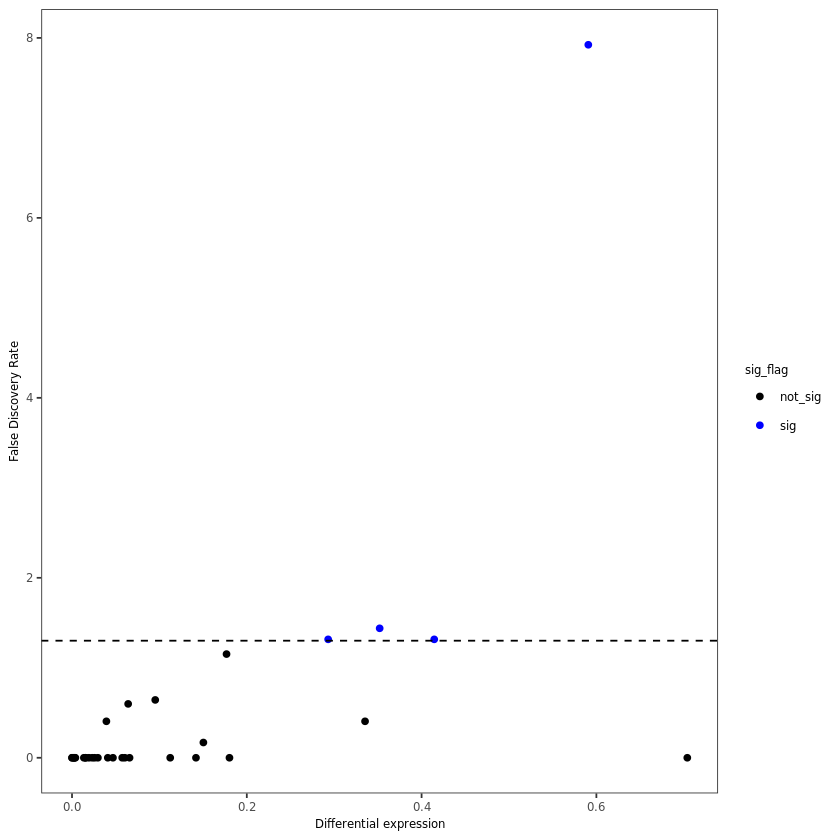

In [70]:
#Plot the plot!
cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene) %>%
data.frame() %>%
rename("pval" = 1, "diff_exp" = 2, "gene" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(diff_exp = as.numeric(diff_exp)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
mutate("abs_diff_exp" = abs(diff_exp)) %>%
mutate("sig_flag" = ifelse(fdr < 0.05, "sig", "not_sig")) %>%
filter(gene %in% all_of(dqtl.significant.genes)) %>%
filter(!gene %in% "CDKN2B") %>%
ggplot(aes(x = abs_diff_exp, y = -log10(fdr), color = sig_flag)) +
geom_point() +

geom_hline(yintercept = 1.301, linetype = 2) +

scale_color_manual(values = c("black", "blue")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("False Discovery Rate") +
xlab("Differential expression")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("diff_exp_scatterplot.pdf", width = 4, height = 2)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp diff_exp_scatterplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [11]:
#Calculate the total number of significant variants so that we can annotate the figure with this information
cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene) %>%
data.frame() %>%
rename("pval" = 1, "diff_exp" = 2, "gene" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(diff_exp = as.numeric(diff_exp)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
mutate("abs_diff_exp" = abs(diff_exp)) %>%
mutate("sig_flag" = ifelse(fdr < 0.05, "sig", "not_sig")) %>%
filter(gene %in% all_of(dqtl.significant.genes)) %>%
arrange(fdr) %>%


head()

,pval,diff_exp,gene,fdr,abs_diff_exp,sig_flag
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,1.020030e-34,-1.9509119,CDKN2B,1.119386e-32,1.9509119,sig
2,2.173588e-10,-0.5907660,IFNE,1.192654e-08,0.5907660,sig
3,9.955677e-04,0.3520314,DMRTA1,3.641804e-02,0.3520314,sig
4,1.631689e-03,0.2930920,CLSPN,4.830639e-02,0.2930920,sig
5,1.760749e-03,-0.4144608,ELAVL2,4.830639e-02,0.4144608,sig
6,2.888061e-03,-0.1768031,RHD,7.043053e-02,0.1768031,not_sig


In [16]:
#Get the names of the most significant genes
eqtl.summary.df = cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene, top.snp.df$snp) %>%
data.frame() %>%
rename("eqtl_pval" = 1, "eqtl_diff_exp" = 2, "gene" = 3, "snp" = 4) %>%
mutate(eqtl_pval = as.numeric(eqtl_pval)) %>%
mutate(eqtl_diff_exp = as.numeric(eqtl_diff_exp)) %>%
mutate("eqtl_fdr" = p.adjust(eqtl_pval, method = "BY", n = length(eqtl_pval))) %>%
mutate("abs_diff_exp" = abs(eqtl_diff_exp)) %>%
mutate("sig_flag" = ifelse(eqtl_fdr < 0.05, "sig", "not_sig")) %>%
arrange(eqtl_fdr)

setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
write.table(eqtl.summary.df, "eqtl_summary_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [120]:
#Calculate the number of significant and non-significant genes
cbind(eqtl.association.pval, eqtl.association.differential.expression, top.snp.df$gene) %>%
data.frame() %>%
rename("pval" = 1, "diff_exp" = 2, "gene" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(diff_exp = as.numeric(diff_exp)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval))) %>%
mutate("abs_diff_exp" = abs(diff_exp)) %>%
mutate("sig_flag" = ifelse(fdr < 0.05, "sig", "not_sig")) %>%
group_by(sig_flag) %>%
summarise("num_of_genes" = n())

sig_flag,num_of_genes
<chr>,<int>
not_sig,41
sig,8


For all of the dQTL genes, calculate the median expression values across all cell lines.

In [27]:
#Calculate the median expression for each gene
expression.per.gene = ancestry.only.expression.22q1 %>% 
group_by(variable) %>%
summarise("median_expression" = median(value)) %>%
mutate("unlogged_expression" = 2^median_expression - 1) %>%
rename("gene" = 1)

#Calculate the number of genes with tpm < 5
less.than.5.tpm = expression.per.gene %>%
filter(unlogged_expression < 5) %>%
pull(gene) %>%
unique() %>%
length()

#Total genes in the analysis
total.genes.in.analysis = expression.per.gene %>%
pull(gene) %>%
unique() %>%
length()

print(paste("there are", less.than.5.tpm, "genes with a tpm less than 5 out of a total of", total.genes.in.analysis, "genes"))

[1] "there are 30 genes with a tpm less than 5 out of a total of 49 genes"


# Expression (pan-essential vs ancestry-associated)

In [ ]:
Compare the expression of pan-essential vs ancestry-associated genes

In [2]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

#Load in the expression data
ccle.expression.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CCLE_expression') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(ccle.expression.22q1) = word(colnames(ccle.expression.22q1), 1)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_ccle-expression.rds



In [5]:
#Get a vector that has all of the ancestry-associated gene names
ancestry.associated.genes = lineage.corrected.pvals %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene)

In [10]:
#Load in a list of common-essential genes
common.essentials <- load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='common_essentials') %>%
mutate(gene = word(gene, 1)) %>%
pull(gene)

head(common.essentials)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_common-essentials.rds



[1] "AAMP"     "AARS1"    "AASDHPPT" "ABCB7"    "ABCE1"    "ABCF1"

In [12]:
ccle.expression.22q1 %>% head()

,sample,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,⋯,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-001113,4.990501,0.0000000,7.273702,2.765535,4.480265,0.02856915,1.26903315,3.058316,6.483171,⋯,1.2141248,0.00000000,0.11103131,0.15055968,1.4276062,5.781884,0,0.00000000,0.7990873,0.00000000
2,ACH-001289,5.209843,0.5459684,7.070604,2.538538,3.510962,0.00000000,0.17632277,3.836934,4.200850,⋯,1.8359241,0.00000000,0.31034012,0.00000000,0.8073549,4.704319,0,0.00000000,0.4646683,0.07038933
3,ACH-001339,3.779260,0.0000000,7.346425,2.339137,4.254745,0.05658353,1.33913738,6.724241,3.671293,⋯,1.8237494,0.08406426,0.17632277,0.04264434,1.3840498,4.931683,0,0.02856915,0.2630344,0.00000000
4,ACH-001538,5.726831,0.0000000,7.086189,2.543496,3.102658,0.00000000,5.91456452,6.099716,4.475733,⋯,0.8718436,0.13750352,0.26303441,2.48542683,0.7136958,3.858976,0,0.00000000,0.0000000,0.00000000
5,ACH-000242,7.465648,0.0000000,6.435462,2.414136,3.864929,0.83187724,7.19800296,5.452530,7.112492,⋯,2.3248106,0.16349873,0.16349873,0.00000000,1.1176950,4.990501,0,0.00000000,0.0000000,0.00000000
6,ACH-000708,4.914086,0.1763228,6.946848,2.577731,3.853996,0.00000000,0.08406426,4.855491,4.934045,⋯,2.3103401,0.12432814,0.05658353,0.08406426,2.4982509,5.303781,0,0.00000000,0.2630344,0.00000000


In [16]:
#Compute the median expression of all genes
median.expression.all.genes = ccle.expression.22q1 %>%
select(-sample) %>%
apply(2, median)

#Compute the median expression for all of the ancestry associated genes
median.expression.ancestry.associated = ccle.expression.22q1 %>%
melt(id = "sample") %>%
filter(variable %in% all_of(ancestry.associated.genes)) %>%
group_by(variable) %>%
summarise("median_value" = median(value)) %>%
pull(median_value)

#Compute the median expression for all of the common essential genes
median.expression.common.essential = ccle.expression.22q1 %>%
melt(id = "sample") %>%
filter(variable %in% all_of(common.essentials)) %>%
group_by(variable) %>%
summarise("median_value" = median(value)) %>%
pull(median_value)


median.expression.all.genes %>% head()
median.expression.ancestry.associated %>% head()
median.expression.common.essential %>% head()

TSPAN6       TNMD       DPM1      SCYL3   C1orf112        FGR 
4.42223300 0.00000000 6.37503943 2.31614574 3.75595577 0.04264434

[1]  3.6170633  4.2265085 10.4628090  0.3103401  3.9634741  4.3708617

[1] 5.305606 7.180307 4.912171 3.817623 3.539779 5.576522

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


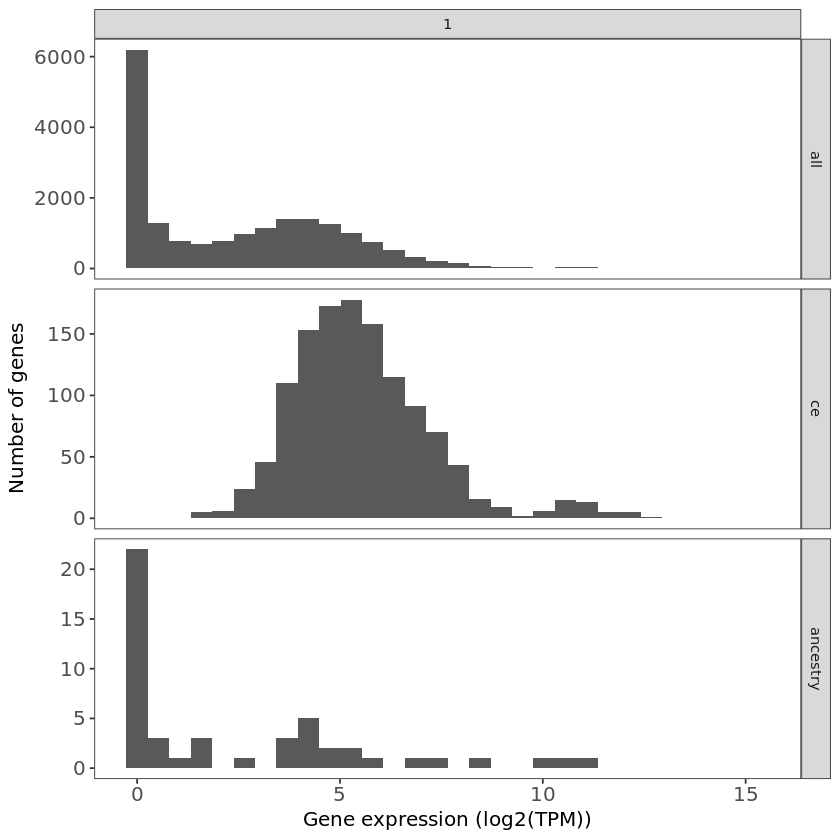

In [39]:
#Compile a data frame that has all of these data
class.vector = c(rep("all", length(median.expression.all.genes)), rep("ancestry", length(median.expression.ancestry.associated)), rep("ce", length(median.expression.common.essential)))
expression.vector = c(median.expression.all.genes, median.expression.ancestry.associated, median.expression.common.essential)

#Plot the plot
cbind(class.vector, expression.vector) %>%
data.frame() %>%
rename("gene_class" = 1, "expression" = 2) %>%
mutate(expression = as.numeric(expression)) %>%
mutate(gene_class = factor(gene_class, levels = c("all", "ce", "ancestry"))) %>%
ggplot(aes(x = expression)) +
geom_histogram(position = "identity") +
facet_grid(gene_class ~ 1, scales = "free") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Number of genes") +
xlab("Gene expression (log2(TPM))")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("rf_expression_distribution_plot.pdf", width = 2, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp rf_expression_distribution_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


# EUR vs EAS for ancestry-associated guides

In [72]:
#First, load in the guide-level data
replicate.map = load.from.taiga(data.name='public-21q4-a0d6', data.version=8, data.file='Achilles_replicate_map')
guide.map = load.from.taiga(data.name='public-21q4-a0d6', data.version=8, data.file='Achilles_guide_map')
logfc = load.from.taiga(data.name='public-21q4-a0d6', data.version=8, data.file='Achilles_logfold_change')

Fetching https://cds.team/taiga/api/dataset/public-21q4-a0d6/8 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-21q4-a0d6_8.toc 


Loading from cached file /home/jupyter/.taiga/41d52e00a90840aa8e822be6c1045772_achilles-replicate-map.rds



Fetching https://cds.team/taiga/api/dataset/public-21q4-a0d6/8 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-21q4-a0d6_8.toc 


Loading from cached file /home/jupyter/.taiga/41d52e00a90840aa8e822be6c1045772_achilles-guide-map.rds



Fetching https://cds.team/taiga/api/dataset/public-21q4-a0d6/8 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-21q4-a0d6_8.toc 


Loading from cached file /home/jupyter/.taiga/41d52e00a90840aa8e822be6c1045772_achilles-logfold-change.rds



In [73]:
#Load in the ancestry information and create two vectors with the EAS and EUR lines
#Load in the ancestry data
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [74]:
###Get a vector of all of the ancestry-associated genes

#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

ancestry.associated.genes = lineage.corrected.pvals %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene)

In [75]:
#Get a list of guides that we want to keep
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% ancestry.associated.genes) %>%
pull(sgrna)

#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
guide.level.data = logfc %>%
data.frame(check.names = FALSE) %>%
rownames_to_column(var = "sgrna") %>%
filter(sgrna %in% all_of(guides.to.keep)) %>%
t() %>%
data.frame() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value)) %>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)



head(guide.level.data)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Using mean(value) as value column: use value.var to override.



,sample,AACACGCTCATCACAATGAG,AACTACCTATGACAGTGCCG,AAGCGGAGACTGTACAGAAA,AAGCTGCTCGATGAGAACAG,AAGGGAAGAAAATTTCCGTG,AATGGACTCTGATATGGAAG,AATTTGAACCTGGCACACAG,ACAACAGGAGAGCAATTTGG,ACAAGACCTTCCGACCCAAG,⋯,TTATTTACTGGTGGCCCTAG,TTCAAGGCAAAAGTCCCGAC,TTCACCTGAGAAGAGTCACC,TTGAGGGAGGAGATTCAGCC,TTGCGGAGCGTGAAGCCGAG,TTTATGAGCCAAGTTCTACC,TTTCATTTATAAGGTGACAA,TTTCCATTAGATATACGAAC,TTTGGACTCGATACACCCCA,TTTGTAGCTGAGCACCAGCA
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000004,-0.23109284,0.5289671,0.4737151,-1.2896670,0.60566837,-0.7291913,0.13714046,0.327575298,0.0352856,⋯,0.29331063,-0.17739040,0.34253030,0.1468307,-0.8643553,-0.55860592,0.3560384640,0.15261984,-0.9222549,0.45962880
2,ACH-000005,-0.33674058,-0.5662708,-0.2013787,-0.5628353,0.09558666,-0.2288458,0.03007088,0.135482243,0.4098391,⋯,-0.12096497,-0.50314176,0.22049825,0.1776621,-0.4231481,-0.07722676,-0.0001681578,-0.55456735,-0.4428227,0.08880842
3,ACH-000007,-0.01096072,-1.1990887,0.2239179,-1.2567061,0.27776196,-0.1882205,0.64521654,-0.304307412,-0.7589919,⋯,0.12749530,0.27960046,0.01013567,0.1867732,-1.3149559,-0.25539100,0.9949785782,0.36405477,-0.8046278,-0.18450655
4,ACH-000009,-0.03523438,-0.5288027,0.2923680,-1.3337604,0.15477538,0.1983357,0.04874993,-0.002724567,0.3486164,⋯,-0.01539607,0.21514607,0.25826291,0.2181543,-0.7843904,-0.71270460,0.2983532567,0.22973644,-1.2492653,0.21227819
5,ACH-000011,-0.33929490,-0.6236395,-0.5274866,-1.0491920,-0.34845970,0.7779661,-0.16717940,1.353222000,-0.5164849,⋯,-0.08604185,-0.06584981,0.14799070,0.4461371,-1.7379950,-1.39359600,0.4816049000,-0.14152450,-1.8192750,0.27600810
6,ACH-000012,0.14476423,-0.3164046,0.3838777,-1.5182617,-0.33269222,0.5494152,-0.38622754,0.411827874,0.3349128,⋯,0.21110063,-0.49172251,0.28279874,0.2585044,-0.7927331,-0.46360112,-0.0179838330,0.02727664,-2.2352693,0.47017185


In [76]:
###Now split the dataset into EAS and EUR cell lines and perform a t-test for each sgRNA

#Split the dataset
eur.scores = guide.level.data %>%
filter(sample %in% all_of(eur.lines))

eas.scores = guide.level.data %>%
filter(sample %in% all_of(eas.lines))

In [77]:
#First, calculate the difference in median across all of the guides
eur.median = eur.scores[2:ncol(eur.scores)] %>% apply(2, median)
eas.median = eas.scores[2:ncol(eas.scores)] %>% apply(2, median)
median.difference = eas.median - eur.median

#Now calculate a t-test between the two
t.test.vector = NULL
for(i in 2:ncol(eur.scores)){
    eas.vector = eas.scores[,i] #get a vector of sgRNA scores for the EAS lines
    eur.vector = eur.scores[,i] #get a vector of sgRNA scores for the EUR lines
    t.test.score = t.test(x = eas.vector, y = eur.vector, alternative = "two.sided")$p.value
    t.test.vector = c(t.test.vector, t.test.score)
}

In [78]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 
head(avana.bed)

,chr,start,end,sgrna
,<chr>,<int>,<dbl>,<chr>
1,chr1,69527,69550,TCTCCATTCGGTGAGCCAGT
2,chr1,168646,168669,TGTAGTCCCAGCTACTCAGG
3,chr1,383420,383443,GAGAATCTCTTGAACCCGGG
4,chr1,424270,424293,TGTAATCCCAGTACTTTGGG
5,chr1,451271,451294,ATAATGGTCAGATAGTGGAG
6,chr1,451344,451367,TCTCCACACCACCAACGACG


In [79]:
#Compile everything into a single data frame
#Also add the guide start and end position
sgrna.names = names(guide.level.data)[2:ncol(guide.level.data)]

compiled.difference.df = cbind(sgrna.names, eur.median, eas.median, t.test.vector) %>%
data.frame() %>%
mutate(eur.median = as.numeric(eur.median)) %>%
mutate(eas.median = as.numeric(eas.median)) %>%
mutate("pval" = as.numeric(t.test.vector)) %>%
rename("sgrna" = 1, "eur_median" = 2, "eas_median" = 3) %>%
mutate("differential" = eur_median - eas_median) %>%
mutate("guide_start_pos" = plyr::mapvalues(from = avana.bed$sgrna, to = avana.bed$start, sgrna, warn_missing = FALSE), .after = sgrna) %>%
mutate("guide_end_pos" = plyr::mapvalues(from = avana.bed$sgrna, to = avana.bed$end, sgrna, warn_missing = FALSE), .after = guide_start_pos) %>%
mutate("guide_chr" = plyr::mapvalues(from = avana.bed$sgrna, to = avana.bed$chr, sgrna, warn_missing = FALSE), .after = sgrna)


row.names(compiled.difference.df) = NULL

head(compiled.difference.df)

,sgrna,guide_chr,guide_start_pos,guide_end_pos,eur_median,eas_median,t.test.vector,pval,differential
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,AACACGCTCATCACAATGAG,chr5,172983885,172983907,-0.01780190,-0.04054945,0.119095081332244,1.190951e-01,0.022747549
2,AACTACCTATGACAGTGCCG,chr1,35764592,35764614,-0.50264663,-0.51017363,0.555678680109014,5.556787e-01,0.007526996
3,AAGCGGAGACTGTACAGAAA,chr4,68567960,68567983,0.09658870,0.22302671,3.15589524430962e-07,3.155895e-07,-0.126438012
4,AAGCTGCTCGATGAGAACAG,chr6,89772666,89772689,-1.34088684,-1.33362991,0.451214944081948,4.512149e-01,-0.007256930
5,AAGGGAAGAAAATTTCCGTG,chr22,29438831,29438853,-0.01785245,-0.04642223,0.260341413442704,2.603414e-01,0.028569773
6,AATGGACTCTGATATGGAAG,chr9,26884853,26884875,0.22373570,0.23142739,0.836124363496915,8.361244e-01,-0.007691692


Calculate which guides have a variant in the target sequence 

In [80]:
#Load in the pre-correction chronos scores
chronos.21q4 = load.from.taiga(data.name='public-21q4-a0d6', data.version=8, data.file='CRISPR_gene_effect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample")
colnames(chronos.21q4) = word(colnames(chronos.21q4), 1)

head(chronos.21q4)

Fetching https://cds.team/taiga/api/dataset/public-21q4-a0d6/8 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-21q4-a0d6_8.toc 


Loading from cached file /home/jupyter/.taiga/41d52e00a90840aa8e822be6c1045772_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13085182,0.04653622,-0.008127864,-0.004798655,-0.105877602,-0.009737021,0.01711245,-0.2998740,0.005238579,⋯,-0.037470062,-0.1177686,-0.03000627,0.10164699,0.12939447,-0.10576105,0.0752984,0.162122484,0.05139971,-0.3206830876
2,ACH-000004,0.07744780,-0.02516893,-0.131097318,-0.025555881,0.063289486,-0.117019353,0.15476132,-0.2071698,0.133319485,⋯,-0.043337142,-0.2598701,0.13691391,0.03896321,0.05778576,0.07885209,-0.1798153,0.144688466,0.15666427,-0.0009599378
3,ACH-000005,-0.08613388,0.05080984,0.089562804,0.174065166,0.049675113,-0.159462978,0.17437388,-0.2906311,-0.102688758,⋯,-0.003433302,-0.2731571,-0.09461930,-0.03924388,-0.07669061,-0.14549734,-0.1256656,0.101487334,0.01669861,-0.1129563722
4,ACH-000007,-0.01966149,-0.09744577,0.081234085,0.063188714,-0.002965134,-0.019375832,-0.03732983,-0.2124637,-0.076449484,⋯,-0.235717694,-0.4622772,0.05763865,0.18708767,0.10066184,-0.03301069,-0.1820360,-0.145871216,-0.19522067,-0.2850142252
5,ACH-000009,-0.03054883,-0.03809544,0.081546077,0.084996859,0.011891553,-0.075494982,-0.01388015,-0.1727562,0.005145085,⋯,-0.158231861,-0.3367013,0.01376237,0.18694181,-0.05805295,-0.13131461,-0.3069837,-0.004764272,-0.06411021,-0.2381547236
6,ACH-000011,0.06388043,-0.04363012,0.037218577,0.176385983,-0.099563282,-0.256687928,-0.05758396,-0.1250950,0.040141661,⋯,-0.602056873,-0.4944074,0.07906482,0.11445670,0.18968679,0.10078370,-0.1113724,-0.136312661,-0.12169263,-0.2008981646


In [81]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })

head(ccle.variant.calls)
dim(ccle.variant.calls)


#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.sample.names.txt
"))

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)
head(sample.names)


final.ancestry.snp.genotyping.matrix = ccle.variant.calls
colnames(final.ancestry.snp.genotyping.matrix) = c("snp", sample.names)
head(final.ancestry.snp.genotyping.matrix)

,V3,V10,V11,V12,V13,V14,V15,V16,V17,V18,⋯,V994,V995,V996,V997,V998,V999,V1000,V1001,V1002,V1003
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1:1407014:G:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1:1471992:T:C,2,2,1,0,1,0,0,0,1,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1:1918305:G:A,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1:2028260:G:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1:2351722:A:G,2,0,1,1,0,0,0,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1:2408761:T:C,1,2,2,2,2,2,1,2,1,⋯,2,2,2,2,1,1,0,2,1,2


[1] 3432  995

[1] "ACH-000657" "ACH-000617" "ACH-000685" "ACH-000632" "ACH-000171"
[6] "ACH-000863"

,snp,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1:1407014:G:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1:1471992:T:C,2,2,1,0,1,0,0,0,1,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1:1918305:G:A,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1:2028260:G:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1:2351722:A:G,2,0,1,1,0,0,0,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1:2408761:T:C,1,2,2,2,2,2,1,2,1,⋯,2,2,2,2,1,1,0,2,1,2


In [82]:
#Filter the genotyping matrix so that it only contains the "eas" or "eur" cell lines
eas.eur.lines.to.keep = c(eas.lines, eur.lines)

genotype.matrix.eas.eur = final.ancestry.snp.genotyping.matrix %>%
select(snp, all_of(eas.eur.lines.to.keep))

In [83]:
###Next step is to figure out if any snp in genotype.matrix.eas.eur maps to a guide in compiled.difference.df
snp.in.guide.vector = NULL
for(i in 1:nrow(compiled.difference.df)){
    
    #store some useful information as variables
    guide.of.interest = compiled.difference.df[i, 1] %>% as.character()
    chr.of.interest = compiled.difference.df[i, 2] %>% as.character()
    guide.start.pos = compiled.difference.df[i, 3] %>% as.numeric()
    guide.end.pos = compiled.difference.df[i, 4] %>% as.numeric()
    
    #Filter genotype.matrix.eas.eur so that it only includes variants that fall within the guide of interest
    variants.in.guide.of.interest = genotype.matrix.eas.eur %>%
    separate(snp, sep = ":", into = c("chr", "pos", "ref", "alt")) %>%
    filter(chr %in% all_of(chr.of.interest)) %>%
    filter(pos >= all_of(guide.start.pos)) %>%
    filter(pos <= all_of(guide.end.pos))
    
    #Calculate the number of variants that map to that guide, then save that to a vector outside of the loop
    num.variants = nrow(variants.in.guide.of.interest)
    snp.in.guide.vector[i] = num.variants
    
}

In [84]:
#create a bridging file for sgrna to gene
sgrna.gene.bridge = guide.map %>%
mutate(gene = word(gene, 1)) %>%
select(sgrna, gene)

#Add the snp information to the main data frame
compiled.difference.with.snp = compiled.difference.df %>%
mutate("snp_status" = snp.in.guide.vector) %>%
mutate("gene" = plyr::mapvalues(from = sgrna.gene.bridge$sgrna, to = sgrna.gene.bridge$gene, sgrna, warn_missing = FALSE), .after = sgrna) %>%
arrange(pval) %>%
select(-t.test.vector) %>%
mutate(snp_status = ifelse(snp_status >= 1, 1, 0)) %>%
mutate(snp_status = as.character(snp_status)) %>%
mutate("fdr" = p.adjust(pval, method = "BY", n = length(pval)), .after = pval)

head(compiled.difference.with.snp)

,sgrna,gene,guide_chr,guide_start_pos,guide_end_pos,eur_median,eas_median,pval,fdr,differential,snp_status
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CTTGAACCTGAAACCAACAG,CLSPN,chr1,35760341,35760363,-0.64057294,0.2532781,2.557744e-46,3.042097e-43,-0.8938511,1
2,GTGGCTTGAGGAAATCCAAG,INCENP,chr11,62128256,62128279,-0.87409914,-1.5227852,3.080443e-16,1.831889e-13,0.6486861,1
3,GCTGTGTCTCCGGAAACTCG,RHD,chr1,25284621,25284643,-0.05206899,-0.2783223,6.544455e-14,2.410616e-11,0.2262534,0
4,CTTCCAGGTCCGCCTTCTGG,CCDC74B,chr2,130141218,130141241,-0.05235231,-0.2885711,8.107222e-14,2.410616e-11,0.2362188,0
5,AGTACCTGCCTCACAGTGCA,RPS5,chr19,58393006,58393029,-1.02039480,-0.3641456,4.756442e-13,1.131431e-10,-0.6562492,1
6,TGCTGTCTCCCAGTACCAGA,QRICH2,chr17,76293785,76293808,0.04648868,0.2418386,4.861846e-12,9.637533e-10,-0.1953499,1


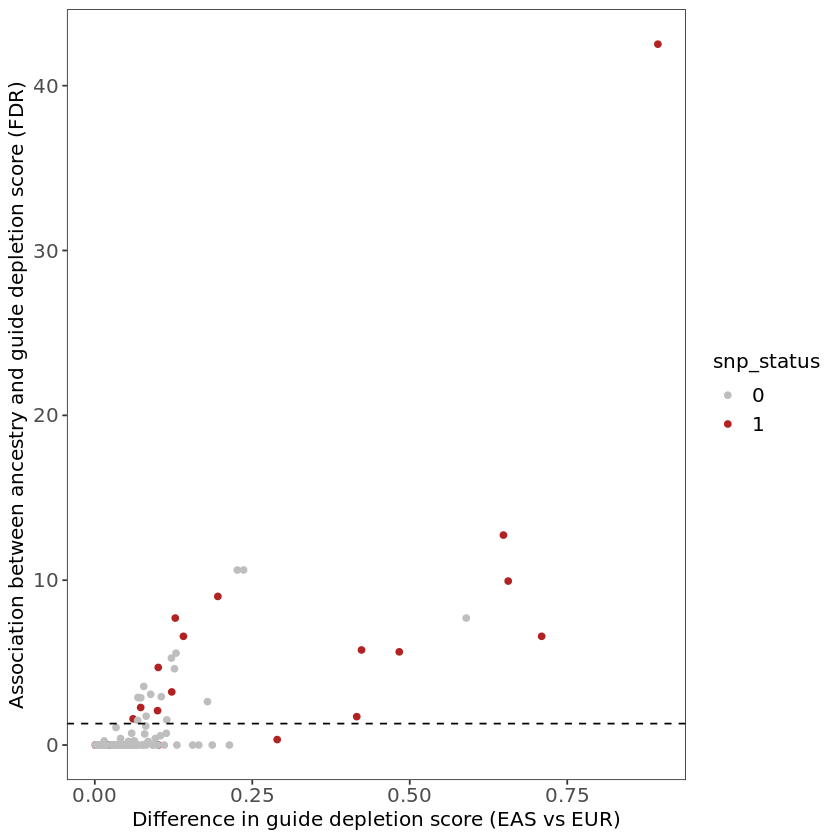

In [85]:
#Make the figure
compiled.difference.with.snp %>%
ggplot(aes(x = abs(differential), y = -log10(fdr), color = snp_status)) +
geom_point() +
geom_hline(yintercept = 1.301, linetype = 2) +
theme_bw() +

scale_color_manual(values = c("grey", "firebrick")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Association between ancestry and guide depletion score (FDR)") +
xlab("Difference in guide depletion score (EAS vs EUR)")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("rf_eas_eur_guide_scatter.pdf", width = 4, height = 2)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp rf_eas_eur_guide_scatter.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


In [93]:
#Compute a p-value for enrichment
with.snp.above.line = compiled.difference.with.snp %>% filter(snp_status %in% 1) %>% filter(fdr < 0.05) %>% nrow()
with.snp.below.line = compiled.difference.with.snp %>% filter(snp_status %in% 1) %>% filter(fdr > 0.05) %>% nrow()
without.snp.above.line = compiled.difference.with.snp %>% filter(snp_status %in% 0) %>% filter(fdr < 0.05) %>% nrow()
without.snp.below.line = compiled.difference.with.snp %>% filter(snp_status %in% 0) %>% filter(fdr > 0.05) %>% nrow()

fisher.matrix <- data.frame(
  "with.snp" = c(with.snp.above.line, with.snp.below.line),
  "without.snp" = c(without.snp.above.line, without.snp.below.line),
  row.names = c("above.line", "below.line"),
  stringsAsFactors = FALSE
)

fisher.matrix

fisher.test(fisher.matrix)

,with.snp,without.snp
,<int>,<int>
above.line,15,15
below.line,10,162



	Fisher's Exact Test for Count Data

data:  fisher.matrix
p-value = 1.335e-08
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  5.577822 47.257751
sample estimates:
odds ratio 
  15.78174 


# Create heatmap

In [98]:
###Get a vector of all of the ancestry-associated genes

#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

ancestry.associated.genes = lineage.corrected.pvals %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene)

In [99]:
#First, load in the sgRNA guide map so that we can get a list of all of the guides that we want to keep
setwd("/home/jupyter/Ancestry/gwas")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",")

#Now subset the data frame so that it only includes the ancestry-associated genes
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% all_of(ancestry.associated.genes)) 
head(guides.to.keep)

dim(guides.to.keep)

,sgrna,genome_alignment,gene,n_alignments
,<chr>,<chr>,<chr>,<int>
1,AACACGCTCATCACAATGAG,chr5_172983890_-,ATP6V0E1,1
2,AACTACCTATGACAGTGCCG,chr1_35764597_-,CLSPN,1
3,AAGCGGAGACTGTACAGAAA,chr4_68567977_+,UGT2B17,1
4,AAGCTGCTCGATGAGAACAG,chr6_89772683_+,MDN1,1
5,AAGGGAAGAAAATTTCCGTG,chr22_29438836_-,RFPL1,1
6,AATGGACTCTGATATGGAAG,chr9_26884858_-,CAAP1,1


[1] 204   4

In [100]:
#First, load in the guide map so that we can figure out which guides are on the plus or minus strand
setwd("/home/jupyter/Ancestry/gwas")
guide.map = guides.to.keep %>%
select(sgrna, genome_alignment) %>%
mutate(genome_alignment = gsub("..*_", "", genome_alignment)) %>%
rename("strand" = genome_alignment)
head(guide.map)

#Load in the Avana bed file to get positions for the ancestry-associated guides
#Also add the annotation information from guides.to.keep to the avana.bed matrix
#Also flip the start and end positions if the sgrna is on the minus strand
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
mutate("true_start" = ifelse(strand %in% "+", start, end)) %>%
mutate("true_end" = ifelse(strand %in% "+", end, start)) %>% #This line and the line above will create two new columns to flip the start and end if the sgrna is on the minus strand
select(chr, true_start, true_end, sgrna) %>%
rename("start" = true_start) %>%
rename("end" = true_end) %>%
inner_join(guides.to.keep, by = "sgrna")

head(avana.bed)
dim(avana.bed)

#We also need to make a bed file that works for SNP filtering, since for bcftools the orientation must always have the smaller value be the start
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed.for.filtering <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
inner_join(guides.to.keep, by = "sgrna")

,sgrna,strand
,<chr>,<chr>
1,AACACGCTCATCACAATGAG,-
2,AACTACCTATGACAGTGCCG,-
3,AAGCGGAGACTGTACAGAAA,+
4,AAGCTGCTCGATGAGAACAG,+
5,AAGGGAAGAAAATTTCCGTG,-
6,AATGGACTCTGATATGGAAG,-


,chr,start,end,sgrna,genome_alignment,gene,n_alignments
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,chr1,25290744,25290767,TGACAGCTTTAGGCAACCTG,chr1_25290761_+,RHD,1
2,chr1,35761099,35761122,ATAGTGCCATGGCATTTCCG,chr1_35761116_+,CLSPN,1
3,chr1,229495882,229495905,GTTTCTTACCCAAATAGCAT,chr1_229495899_+,NUP133,1
4,chr1,229500759,229500782,GTAGAATGTGCTTCACCTGA,chr1_229500776_+,NUP133,1
5,chr2,20447539,20447562,CAGTAAGGACGAGTTCCCCG,chr2_20447556_+,RHOB,1
6,chr2,20447626,20447649,GCTGGCGCTGTGGGACACGG,chr2_20447643_+,RHOB,1


[1] 208   7

In [101]:
#Format avana.bed as an actual bed file, then export it
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
bed.for.export = avana.bed.for.filtering %>%
select(chr, start, end, sgrna)
write.table(bed.for.export, "ancestry.associated.sgrna.ranges.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)


#Now use bcftools to subset the big ccle snp matrix to only include SNPs in that range
system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
/home/jupyter/Ancestry/software/bcftools/bcftools view -R /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/ancestry.associated.sgrna.ranges.bed split.all_chroms.maf.subset.reheader.vcf.gz -o /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/snps.in.ancestry.guides.vcf.gz -Oz
"))

In [102]:
#Now load in the subset vcf file and format it
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
subset.ccle.snps = read.table("snps.in.ancestry.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub(":..*", "", x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("0\\|0", 0, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("0\\|1", 1, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("1\\|0", 1, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
subset.ccle.snps = subset.ccle.snps %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

head(subset.ccle.snps)
dim(subset.ccle.snps)

,chr,pos,ref,alt,V10,V11,V12,V13,V14,V15,⋯,V994,V995,V996,V997,V998,V999,V1000,V1001,V1002,V1003
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,19257510,G,A,1,0,0,1,2,0,⋯,0,0,0,2,1,0,1,0,1,0
2,chr1,35760347,T,C,1,0,1,1,2,0,⋯,1,2,0,2,0,0,0,0,1,0
3,chr1,52854602,G,T,1,2,1,2,2,2,⋯,1,0,2,2,1,1,2,0,1,2
4,chr1,54716627,T,A,1,1,2,2,1,0,⋯,0,2,2,0,1,0,2,2,1,1
5,chr1,54722709,C,T,1,0,2,0,0,0,⋯,0,0,1,0,0,0,0,0,1,0
6,chr2,28869984,G,T,0,0,1,1,0,0,⋯,0,2,2,0,0,1,2,1,1,0


[1]  63 998

In [103]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
    
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = subset.ccle.snps %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [104]:
#Now create a matrix where each row is a guide and each column is a position (1-20 + 3) that is coded with 0 and 1
#1 means there is a snp in that position in at least one cell line

output.matrix = NULL
for(i in 1:length(snp.in.guide.list)){
    
    snp.position.vector = snp.in.guide.list[[i]] %>% abs() #get a vector with the snp positions
    position.with.snp = intersect(snp.position.vector, 1:23) #find the snps that map to guides or the PAM sequence
    
    #now create the final vector
    final.vector = rep(0, 23)
    final.vector[position.with.snp] <- 1
    
    #save the output vector to the matrix
    output.matrix = rbind(output.matrix, final.vector)
}
output.matrix = output.matrix %>% data.frame()

In [105]:
#Export the output.matrix so that we can use it for other purposes
output.matrix.for.export = output.matrix %>%
mutate("sgrna" = avana.bed$sgrna, .before = 1)

head(output.matrix.for.export)

#Now export it
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
write.table(output.matrix.for.export, "locus_ancestry_guide_snp_positions.txt", sep = "\t", row.names = TRUE, col.names = TRUE, quote = FALSE)

,sgrna,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
final.vector,TGACAGCTTTAGGCAACCTG,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
final.vector.1,ATAGTGCCATGGCATTTCCG,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
final.vector.2,GTTTCTTACCCAAATAGCAT,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
final.vector.3,GTAGAATGTGCTTCACCTGA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
final.vector.4,CAGTAAGGACGAGTTCCCCG,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
final.vector.5,GCTGGCGCTGTGGGACACGG,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [106]:
#Format the dataset for plotting a heatmap
output.matrix.for.plotting = output.matrix %>%
mutate("sgrna" = names(snp.in.guide.list), .before = 1) %>%
mutate("gene" = sgrna, .after = sgrna) %>%
mutate(gene = plyr::mapvalues(gene, from = avana.bed$sgrna, to = avana.bed$gene, warn_missing = FALSE)) %>%
select(-sgrna) %>% #remove the sgrna column
melt() %>%
group_by(gene, variable) %>%
summarise(max(value)) %>%
rename("value" = 3)

head(output.matrix.for.plotting)


#calculate the number of SNPs per gene
snps.per.gene = output.matrix.for.plotting %>%
group_by(gene) %>%
summarise(sum(value)) %>%
rename("value" = 2) %>%
arrange(-value)

Using gene as id variables

`summarise()` has grouped output by 'gene'. You can override using the
`.groups` argument.


gene,variable,value
<chr>,<fct>,<dbl>
ABHD5,X1,0
ABHD5,X2,0
ABHD5,X3,0
ABHD5,X4,0
ABHD5,X5,0
ABHD5,X6,0


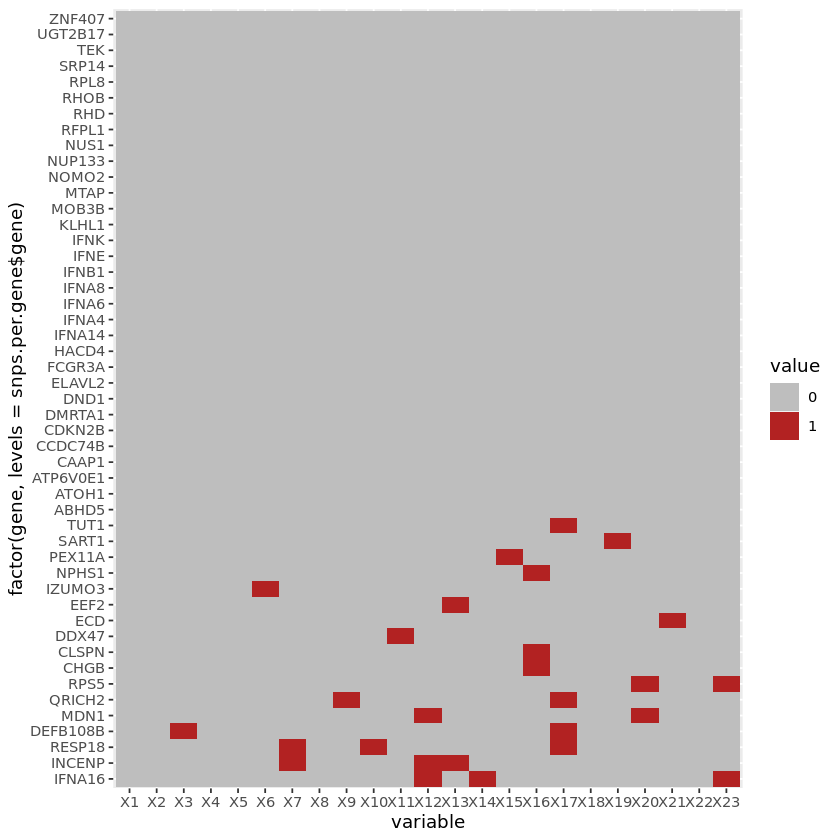

In [111]:
#Now plot the heatmap
output.matrix.for.plotting %>%
mutate(value = as.character(value)) %>%
ggplot(aes(x = variable, y = factor(gene, levels = snps.per.gene$gene), fill = value)) + 
geom_tile() +
scale_fill_manual(values = c("grey", "firebrick"))

#And export it to the bucket
#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("rf_locus_ccle_snp_heatmap.pdf", width = 3, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp rf_locus_ccle_snp_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Make dQTL sig plot (Figure 2A)

In [1]:
#Load in all of the p-values
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction/gwas_output")
all.data = read.table("merged.pvals.txt", sep = "\t", header = TRUE)

In [4]:
#Compute FDRs for all genes
all.data.fdr = all.data %>%
select(-snp) %>%
apply(2, function(x){
    p.adjust(x, method = "BY", n = length(x))
}) %>%
data.frame() %>%
mutate("snp" = all.data$snp, .before = 1)

In [5]:
#Melt the dataset
all.data.fdr.melted = all.data.fdr %>%
melt(id = "snp")

In [6]:
#Load in the top SNP data
setwd("/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

top.snp.df %>% head()

,gene,snp,pval,fdr
,<chr>,<chr>,<dbl>,<dbl>
1,ABHD5,chr19:10327278:A:G,9.99055e-08,1.000000e+00
2,ATOH1,chr6:117239254:T:C,1.85815e-26,3.064682e-18
3,ATP6V0E1,chr2:15148916:G:A,5.42604e-12,7.200293e-04
4,CAAP1,chr9:26820990:G:A,1.60688e-07,1.000000e+00
5,CCDC74B,chr3:70154405:A:C,2.08891e-07,1.000000e+00
6,CDKN2B,chr9:21986219:C:T,1.63496e-15,2.696571e-07


In [7]:
#Load in the merged frequency dataset
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
merged.frequency.dataset = read.table("merged_frequency_dataset.txt", sep = "\t", header = TRUE)

merged.frequency.dataset %>% head()

,snp,num_alleles_afr,num_alleles_eas,num_alleles_eur,num_alleles_admixed,num_alleles_total,afr_allele_fraction,eas_allele_fraction,eur_allele_fraction,admixed_allele_fraction,total_allele_fraction
,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:109297547:C:T,0,0,16,0,16,0.000,0.000000000,0.020833333,0.000,0.012638231
2,chr1:161637565:G:T,20,149,494,16,683,0.500,0.359903382,0.643229167,0.400,0.539494471
3,chr1:230980609:C:T,0,1,7,1,9,0.000,0.002415459,0.009114583,0.025,0.007109005
4,chr1:25235176:G:A,2,8,260,10,283,0.050,0.019323671,0.338541667,0.250,0.223538705
5,chr1:35775729:T:C,15,95,663,24,798,0.375,0.229468599,0.863281250,0.600,0.630331754
6,chr1:73819660:G:A,1,0,13,0,14,0.025,0.000000000,0.016927083,0.000,0.011058452


In [8]:
#Merge the two datasets together
merged.top.snp.and.frequency = inner_join(top.snp.df, merged.frequency.dataset, by = "snp")

merged.top.snp.and.frequency %>% head()
merged.top.snp.and.frequency %>% dim()

,gene,snp,pval,fdr,num_alleles_afr,num_alleles_eas,num_alleles_eur,num_alleles_admixed,num_alleles_total,afr_allele_fraction,eas_allele_fraction,eur_allele_fraction,admixed_allele_fraction,total_allele_fraction
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ABHD5,chr19:10327278:A:G,9.99055e-08,1.000000e+00,25,181,350,16,574,0.625,0.43719807,0.455729167,0.400,0.45339652
2,ATOH1,chr6:117239254:T:C,1.85815e-26,3.064682e-18,40,414,768,38,1264,1.000,1.00000000,1.000000000,0.950,0.99842022
3,ATP6V0E1,chr2:15148916:G:A,5.42604e-12,7.200293e-04,2,24,1,0,27,0.050,0.05797101,0.001302083,0.000,0.02132701
4,CAAP1,chr9:26820990:G:A,1.60688e-07,1.000000e+00,4,7,11,0,22,0.100,0.01690821,0.014322917,0.000,0.01737757
5,CCDC74B,chr3:70154405:A:C,2.08891e-07,1.000000e+00,2,0,335,9,346,0.050,0.00000000,0.436197917,0.225,0.27330174
6,CDKN2B,chr9:21986219:C:T,1.63496e-15,2.696571e-07,15,69,138,9,231,0.375,0.16666667,0.179687500,0.225,0.18246445


[1] 49 14

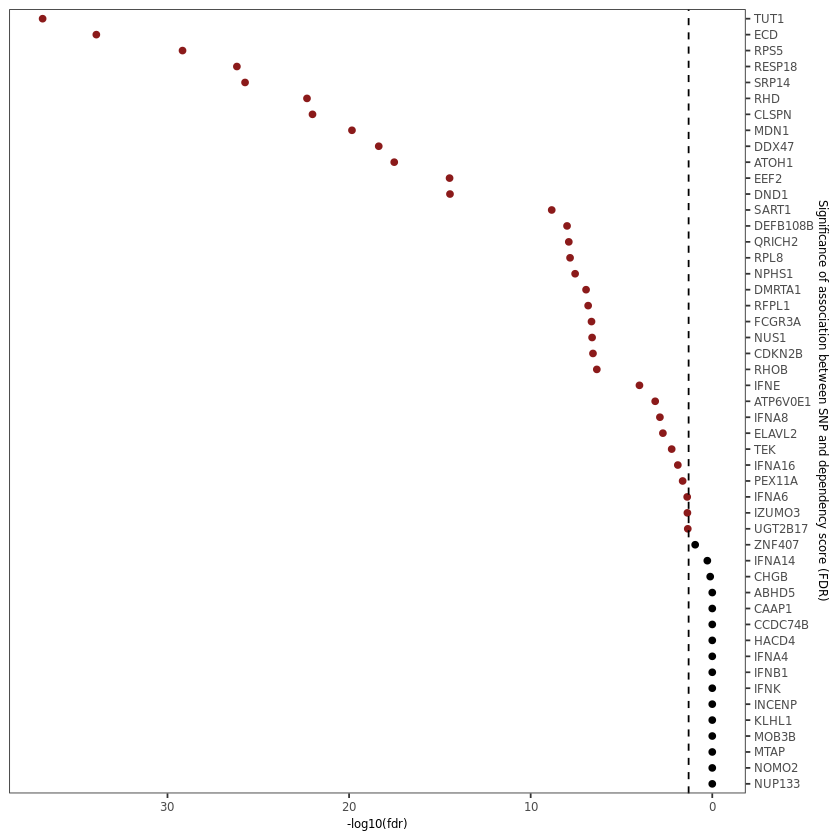

In [13]:
merged.top.snp.and.frequency %>%
arrange(fdr) %>%
mutate(gene = factor(gene, levels = gene)) %>%
mutate("color_flag" = ifelse(fdr > 0.05, FALSE, TRUE)) %>%
ggplot(aes(x = -log10(fdr), y = gene, color = color_flag)) +
geom_point() +

scale_color_manual(values = c("black", "firebrick4")) + 

geom_vline(xintercept = 1.302, linetype = 2) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_discrete(position = "right", limits = rev) +
scale_x_reverse() +

theme(
legend.position = "none"
) +

ylab("Significance of association between SNP and dependency score (FDR)") 

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("sig_top_snp_plot.pdf", width = 2, height = 4.5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp sig_top_snp_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

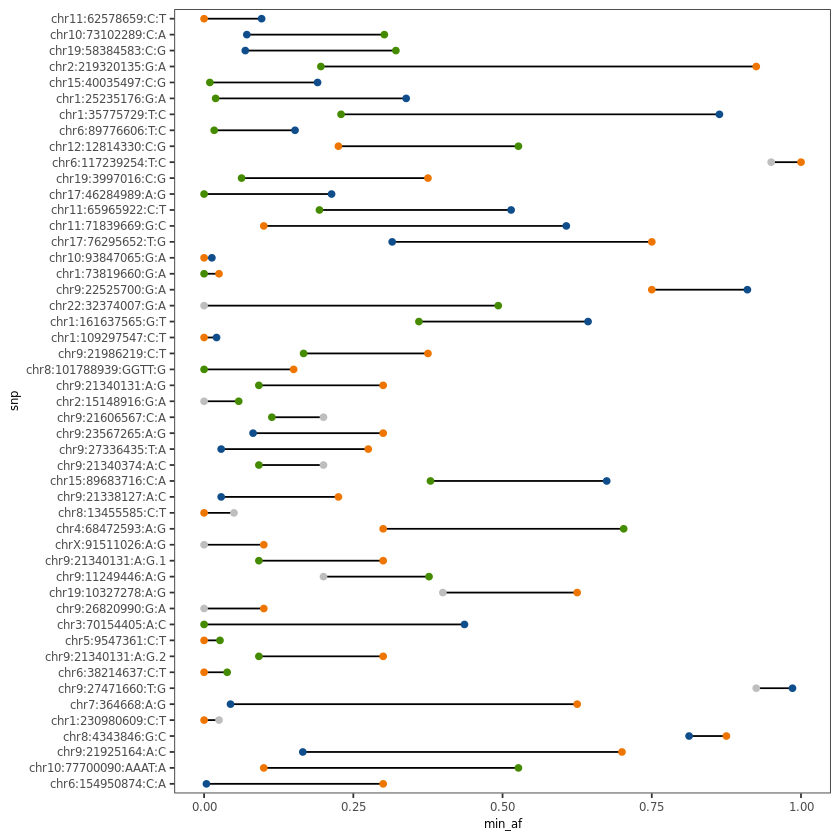

In [12]:
#Plot the other plotaroonie
merged.top.snp.and.frequency %>%
arrange(fdr) %>%
mutate(snp = make.unique(snp)) %>%
#mutate("num" = seq(from = 1, to = nrow(.), by = 1)) %>%
mutate(snp = factor(snp, levels = snp)) %>%
select(snp, gene, afr_allele_fraction, eas_allele_fraction, eur_allele_fraction, admixed_allele_fraction) %>%
mutate("min_af" = pmin(afr_allele_fraction, eas_allele_fraction, eur_allele_fraction, admixed_allele_fraction)) %>%
mutate("max_af" = pmax(afr_allele_fraction, eas_allele_fraction, eur_allele_fraction, admixed_allele_fraction)) %>%
mutate("min_color_flag" = ifelse(min_af == afr_allele_fraction, "afr",
                                ifelse(min_af == eas_allele_fraction, "eas",
                                      ifelse(min_af == eur_allele_fraction, "eur",
                                            ifelse(min_af == admixed_allele_fraction, "admixed", "NA"))))) %>%
mutate("max_color_flag" = ifelse(max_af == afr_allele_fraction, "afr",
                                ifelse(max_af == eas_allele_fraction, "eas",
                                      ifelse(max_af == eur_allele_fraction, "eur",
                                            ifelse(max_af == admixed_allele_fraction, "admixed", "NA"))))) %>%
ggplot() +
geom_segment(aes(x = min_af, xend = max_af, y = snp, yend = snp, color = "grey")) +
geom_point(aes(x = min_af, y = snp, color = min_color_flag)) +
geom_point(aes(x = max_af, y = snp, color = max_color_flag)) +

scale_color_manual(values = c("grey", "darkorange2", "chartreuse4", "dodgerblue4", "black")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_discrete(limits = rev) +

theme(
legend.position = "none"
) 


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("af_dumbell_plot.pdf", width = 3, height = 4.5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp af_dumbell_plot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Which ancestry-associated genes have SNPs?

In [41]:
#Load in the depmap blacklist matrix
avana.blacklist.matrix = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='OmicsGuideMutationsBinaryAvana')
chronos.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect')
avana.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='AvanaGuideMap') %>%
mutate(Gene = word(Gene, 1))

Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_omicsguidemutationsbinaryavana.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_avanaguidemap.rds



In [54]:
#Get a vector of ancestry-associated genes
#Make a vector of all of the ancestry-associated genes
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [56]:
#Get a vector of cell lines that are profiled in 22q1
chronos.lines = row.names(chronos.22q1) %>% unique()

#Process and filter the avana.guide.map
filtered.avana.blacklist.matrix = avana.blacklist.matrix %>%
select(-chrom, -start, -end) %>%
rename("sgrna" = sgRNA) %>%
melt(id = "sgrna") %>%
rename("sample" = variable, "status" = value) %>%
filter(sample %in% all_of(chronos.lines)) %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgRNA, to = avana.guide.map$Gene, sgrna, warn_missing = FALSE))


filtered.avana.blacklist.matrix %>% head()

,sgrna,sample,status,gene
,<chr>,<fct>,<int>,<chr>
1,TGTAGTCCCAGCTACTCAGG,ACH-000078,0,INTERGENIC_chr10
2,TGCAATGGCGAGGAATACCG,ACH-000078,0,INTERGENIC_chr1
3,GGTAGCCCTCACCCTTCCCG,ACH-000078,0,INTERGENIC_chr1
4,TGTAGTCCCAGCTACTCAGG,ACH-000078,0,INTERGENIC_chr10
5,TGTAGTCCCAGCTACTCAGG,ACH-000078,0,INTERGENIC_chr10
6,GAGTATTCAGTGTTACCTGG,ACH-000078,0,INTERGENIC_chr1


In [66]:
#Calculate the number of ancestry-associated genes that are affected
ancestry.associated.genes.affected = filtered.avana.blacklist.matrix %>%
filter(gene %in% all_of(ancestry.associated.gene.vector)) %>%
group_by(gene) %>%
summarise("num_affected" = sum(status)) %>%
filter(num_affected > 0) %>%
pull(gene) %>%
unique() %>%
length()

print(paste("the number of ancestry-associated genes that are affected in 22q1 is:", ancestry.associated.genes.affected))


#Calculate the total number of genes that are affected
total.genes.affected = filtered.avana.blacklist.matrix %>%
filter(!str_detect(gene, "INTERGENIC")) %>% 
group_by(gene) %>%
summarise("num_affected" = sum(status)) %>%
filter(num_affected > 0) %>%
pull(gene) %>%
unique() %>%
length()


print(paste("the number of genes that are affected in 22q1 is:", total.genes.affected))


#Calculate the total number of genes in the dataset
total.genes = filtered.avana.blacklist.matrix %>%
pull(gene) %>% 
unique() %>%
length()

print(paste("the total number of genes in the dataset is:", total.genes))


[1] "the number of ancestry-associated genes that are affected in 22q1 is: 38"
[1] "the number of genes that are affected in 22q1 is: 14274"
[1] "the total number of genes in the dataset is: 18341"


In [72]:
#Calculate the total number of guides targeting the ancestry-associated genes
num.guides.targeting.ancestry.associated.genes = filtered.avana.blacklist.matrix %>%
filter(gene %in% all_of(ancestry.associated.gene.vector)) %>%
pull(sgrna) %>%
unique() %>%
length()

num.guides.targeting.ancestry.associated.genes

[1] 183

In [17]:
#Load in the chronos data and format it
ccle.chronos = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

#Load in the 22Q2 chronos scores
ccle.chronos.new = load.from.taiga(data.name = 'public-22q2-de04', data.version = 13, data.file = 'CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos.new)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/13 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_13.toc 


Loading from cached file /home/jupyter/.taiga/1cafd2994fbd42bfa073735fd1df8fb1_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13480834,0.05976414,-0.008665348,-0.003572187,-0.10621134,-0.008256886,0.01871112,-0.2919850,0.010921115,⋯,-0.03761858,-0.1165238,-0.02933128,0.10593958,0.14760478,-0.11982188,0.06338746,0.160857427,0.05864839,-0.31679247
2,ACH-000004,0.08185267,-0.05640053,-0.106737674,-0.014498538,0.07820912,-0.137561629,0.16865681,-0.1985604,0.133372221,⋯,-0.03090052,-0.2622202,0.13640560,0.03132672,0.09376340,-0.07969233,-0.17370934,0.153631719,0.17562738,-0.04086936
3,ACH-000005,-0.09419603,-0.01459842,0.100426025,0.169102790,0.03236276,-0.148049517,0.16893121,-0.2447774,-0.086870802,⋯,0.03943419,-0.3369248,-0.09552776,-0.03554091,-0.03561198,-0.04018275,-0.16546361,0.077343176,0.01938719,-0.08568671
4,ACH-000007,-0.01154405,-0.12318890,0.080692206,0.061045542,-0.01345373,-0.016922117,-0.02947437,-0.2065158,-0.063998364,⋯,-0.22930329,-0.4631913,0.06164065,0.19030097,0.11938844,-0.03669501,-0.18244891,-0.146936282,-0.18945093,-0.28116666
5,ACH-000009,-0.05078233,-0.03746616,0.068885471,0.090375004,0.01263396,-0.079339046,-0.01780849,-0.1831923,0.006227123,⋯,-0.15721917,-0.3187652,0.01576143,0.19694914,-0.04587438,-0.18680541,-0.27562864,-0.001227225,-0.04913985,-0.24058191
6,ACH-000011,0.09176169,-0.02468473,0.038251266,0.202305191,-0.08956827,-0.238266134,-0.04224042,-0.1039025,0.048108927,⋯,-0.58992360,-0.4832944,0.06334174,0.11549458,0.20633287,0.09252132,-0.10991214,-0.121556159,-0.11373265,-0.20934415


In [18]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [ ]:
#Filter the two datasets so that they have overlapping samples and genes
overlapping.samples = intersect(ccle.chronos$sample, ccle.chronos.new$sample) %>%
intersect()

chronos.22q1.filtered = ccle.chronos %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample)

chronos.22q2.filtered = ccle.chronos.new %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample)

# pre-post correction scatter with lineage correction

# IN PROGRESS: Figure 3 propaganda heatmap

In [7]:
#Load in the guide avana blacklist
avana.blacklist.map = avana.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='OmicsGuideMutationsBinaryAvana') %>%
rename("chr" = 1, "start_pos" = 2, "end_pos" = 3, "sgrna" = 4)

#Load in the guide map
avana.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='AvanaGuideMap') %>%
rename("sgrna" = 1, "genome_alignment" = 2, "gene" = 3, "n_alignments" = 4, "drop_reason" = 5, "used_by_chronos" = 6) %>%
mutate(gene = word(gene, 1))

Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_omicsguidemutationsbinaryavana.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_avanaguidemap.rds



In [36]:
#Load in the ancestry annotation for all of the cell lines
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of african cell lines
setwd("/home/jupyter/Ancestry/rfmix")
afr.cell.lines = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T) %>%
filter(AFR > 0.8) %>%
pull(sample) %>%
unique()

ancestry.information %>% head()
afr.cell.lines

,sample,AFR,AMR,EAS,EUR,SAS
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


[1] "ACH-000657"   "ACH-000685"   "ACH-001015"   "ACH-000839"   "ACH-000748"  
 [6] "ACH-000772"   "ACH-000834"   "ACH-000349"   "ACH-000707"   "ACH-000691"  
[11] "ACH-000866"   "ACH-000612"   "ACH-000717"   "ACH-000887"   "ACH-001079"  
[16] "ACH-001225"   "ACH-000789"   "ACH-000924"   "ACH-000624"   "ACH-001064"  
[21] "ACH-000786"   "ACH-000877"   "ACH-000386"   "ACH-000878"   "ACH-000944"  
[26] "ACH-000849"   "ACH-000763"   "ACH-001318"   "ACH-000621"   "ACH-000759"  
[31] "ACH-001318.1" "ACH-000943"   "ACH-000797"   "ACH-000654"   "ACH-000462"  
[36] "ACH-000929"   "ACH-000952"   "ACH-000538"   "ACH-000429"   "ACH-001075"  
[41] "ACH-000930"

In [12]:
#format the dataset to create a gene x cell line df with blacklist or no blacklist encoded as 0 or 1
formatted.blacklist.map = avana.blacklist.map %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgrna, to = avana.guide.map$gene, sgrna, warn_missing = FALSE), .before = sgrna) %>%
select(-chr, -start_pos, -end_pos, -sgrna)

In [15]:
#Load in the COSMIC tier 1 genes and create a vector of gene names
setwd("/home/jupyter/Ancestry/analysis/cosmic_heatmap")
cosmic.genes = read.table("cosmic_genes.csv", sep = ",", header = T)

cosmic.tier1 = cosmic.genes %>% 
filter(Tier %in% "1") %>%
pull(Gene.Symbol)

length(cosmic.tier1)

[1] 579

In [25]:
#Filter formatted.blastlist.map so it only contains cosmic genes
#Also collapse the gene names
cosmic.formatted.blacklist.map = formatted.blacklist.map %>%
filter(gene %in% all_of(cosmic.tier1)) %>%
group_by(gene) %>%
summarise(across(everything(), sum)) %>%
mutate(across(-gene, ~ ifelse(. > 1, 1, .)))


cosmic.formatted.blacklist.map %>% head()

gene,ACH-000440,ACH-002947,ACH-000078,ACH-002946,ACH-001552,ACH-000392,ACH-000736,ACH-001172,ACH-001210,⋯,ACH-000832,ACH-000869,ACH-000985,ACH-002245,ACH-000776,ACH-000944,ACH-000125,ACH-000564,ACH-001626,ACH-000591
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ABI1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ABL1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ABL2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ACKR3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ACSL3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ACVR1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [37]:
#Go through all of the cell lines and get a dataframe that has which genes are affected in each cell line
#Filter it to only include african cell lines
affected.gene.list = cosmic.formatted.blacklist.map %>% 
melt() %>%
filter(value %in% "1") %>%
select(-value) %>%
rename("sample" = variable) %>%
filter(sample %in% all_of(afr.cell.lines))

affected.gene.list %>% head()

Using gene as id variables



,gene,sample
,<chr>,<fct>
1,PREX2,ACH-000839
2,DCTN1,ACH-000849
3,FAT4,ACH-000849
4,IL7R,ACH-000849
5,NRG1,ACH-000849
6,PHOX2B,ACH-000849


In [38]:
#Get a vector of all unique cell lines
unique.cell.lines = affected.gene.list %>%
pull(sample) %>%
unique() %>%
as.character()

In [46]:
#Now loop through everything and compute an intersection matrix
intersection.matrix = NULL
for(line in unique.cell.lines){
    
    affected.gene.v1 = affected.gene.list %>% filter(sample %in% all_of(line)) %>% pull(gene) %>% unique()
    
    intersection.vector = NULL
    for(i in 1:length(unique.cell.lines)){
        
        #Extract a vector of affected genes
        second.line.of.interest = unique.cell.lines[i]
        affected.gene.vi = affected.gene.list %>% filter(sample %in% all_of(second.line.of.interest)) %>% pull(gene) %>% unique()
        
        #Calculate the intersection length
        intersection.length = intersect(affected.gene.v1, affected.gene.vi) %>% length()
        
        #Export it outside of the loop
        intersection.vector[i] = intersection.length    
    }
    
    #Now export the final vector to outside of the loop and store it as a df
    intersection.matrix = cbind(intersection.matrix, intersection.vector)
    
    
}

#Rename the matrix
colnames(intersection.matrix) = unique.cell.lines 
intersection.matrix = intersection.matrix %>%
data.frame() %>%
mutate("sample" = unique.cell.lines, .before = 1)

In [47]:
intersection.matrix %>% head()

,sample,ACH.000839,ACH.000849,ACH.000717,ACH.000748,ACH.001318,ACH.000621,ACH.000943,ACH.000386,ACH.001075,⋯,ACH.000429,ACH.000786,ACH.000929,ACH.000763,ACH.000887,ACH.000924,ACH.000789,ACH.000930,ACH.000877,ACH.001064
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000839,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000849,0,5,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
3,ACH-000717,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
4,ACH-000748,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,ACH-001318,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,ACH-000621,0,0,0,0,0,5,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0


In [ ]:
intersection.matrix %>%
data.frame() %>%
ggplot(aes(x =))

In [48]:
intersection.matrix %>% 
melt() %>%
head()

Using sample as id variables



,sample,variable,value
,<chr>,<fct>,<int>
1,ACH-000839,ACH.000839,1
2,ACH-000849,ACH.000839,0
3,ACH-000717,ACH.000839,0
4,ACH-000748,ACH.000839,0
5,ACH-001318,ACH.000839,0
6,ACH-000621,ACH.000839,0


In [40]:
unique.cell.lines %>% length()

[1] 26

In [41]:
26*26

[1] 676

# Pre-post correction scatterplot (Figure 4)

This analysis will use data that was already processed in the Reviewer 4 notebook.

In [2]:
#Load in the data
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_4")
lm.pval.df.22q1 = read.table("chronos_22q1_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)
lm.pval.df.22q2 = read.table("chronos_22q2_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

In [6]:
#Collect the minimum fdr for each gene and for each dataset
min.fdr.22q1 = lm.pval.df.22q1 %>%
rowwise() %>%
mutate("min_fdr_22q1" = min(across(afr_fdr:sas_fdr))) %>%
select(gene, min_fdr_22q1)

min.fdr.22q2 = lm.pval.df.22q2 %>%
rowwise() %>%
mutate("min_fdr_22q2" = min(across(afr_fdr:sas_fdr))) %>%
select(gene, min_fdr_22q2)

#Bind the two datasets together
min.fdr.both.datasets.df = inner_join(min.fdr.22q1, min.fdr.22q2, by = "gene")

min.fdr.both.datasets.df %>% head()




gene,min_fdr_22q1,min_fdr_22q2
<chr>,<dbl>,<dbl>
A1BG,0.9184664,0.9052003
A1CF,0.9771815,0.9848630
A2M,0.9548815,0.9479719
A2ML1,0.7843746,0.8029020
A3GALT2,0.9753693,0.9848630
A4GALT,0.8209225,0.8367271


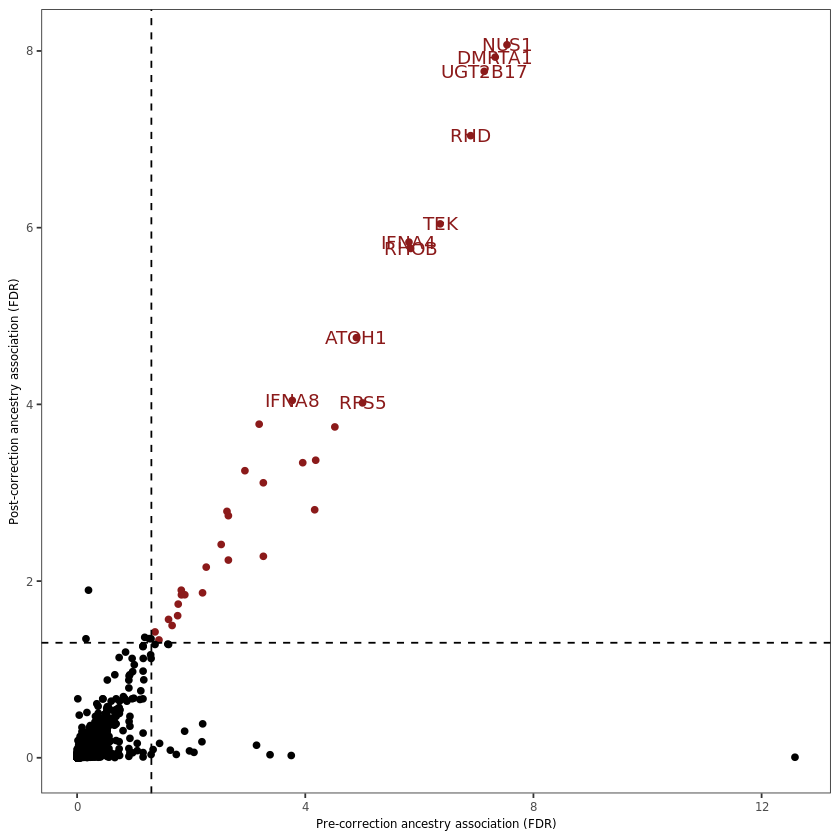

In [17]:
#Plot the scatterplot
scatterplot.df = min.fdr.both.datasets.df %>%
mutate("sig_flag" = ifelse(min_fdr_22q1 < 0.05 & min_fdr_22q2 < 0.05, TRUE, FALSE)) 

scatterplot.df %>%
ggplot(aes(x = -log10(min_fdr_22q1), y = -log10(min_fdr_22q2), color = sig_flag)) +
geom_point() +

scale_color_manual(values = c("black", "firebrick4")) +

geom_hline(yintercept = 1.302, linetype = 2) +
geom_vline(xintercept = 1.302, linetype = 2) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
legend.position = "none"
) +

ylab("Post-correction ancestry association (FDR)") +
xlab("Pre-correction ancestry association (FDR)") +

geom_text(
data = filter(scatterplot.df, min_fdr_22q2 < 0.0001), aes(label = gene)
)

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/remake_figures_lineage_correction')
ggsave("pre_post_correction_scatterplot.pdf", width = 3, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/remake_figures_lineage_correction
gsutil cp pre_post_correction_scatterplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [22]:
#Calculate the number of significant genes

sig.in.22q1 = scatterplot.df %>% filter(min_fdr_22q1 < 0.05)
sig.in.22q2 = scatterplot.df %>% filter(min_fdr_22q2 < 0.05)
sig.in.22q1.not.22q2 = scatterplot.df %>% filter(min_fdr_22q1 < 0.05 & min_fdr_22q2 > 0.05)
sig.in.22q2.not.22q1 = scatterplot.df %>% filter(min_fdr_22q1 > 0.05 & min_fdr_22q2 < 0.05)
sig.in.22q1.and.22q2 = scatterplot.df %>% filter(min_fdr_22q1 < 0.05 & min_fdr_22q2 < 0.05)

sig.in.22q1 %>% nrow()
sig.in.22q2 %>% nrow()
sig.in.22q1.not.22q2 %>% nrow()
sig.in.22q2.not.22q1 %>% nrow()
sig.in.22q1.and.22q2 %>% nrow()

[1] 49

[1] 38

[1] 16

[1] 5

[1] 33

In [18]:
scatterplot.df %>% head()

gene,min_fdr_22q1,min_fdr_22q2,sig_flag
<chr>,<dbl>,<dbl>,<lgl>
A1BG,0.9184664,0.9052003,FALSE
A1CF,0.9771815,0.9848630,FALSE
A2M,0.9548815,0.9479719,FALSE
A2ML1,0.7843746,0.8029020,FALSE
A3GALT2,0.9753693,0.9848630,FALSE
A4GALT,0.8209225,0.8367271,FALSE
